In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import interpolate
import numpy as np
import cv2
import random
import pandas as pd
from operator import itemgetter

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import imblearn

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, InputLayer, BatchNormalization
from matplotlib import pyplot as plt
from matplotlib import cm

C:\Users\akhme\miniconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
def fitting_flat(x_train, y_train):
    # create model
    model = Sequential()
    model.add(Dense(450, input_dim=450, activation='relu'))
    model.add(Dense(450, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(45, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(45, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=50, batch_size=32, verbose = 0)
    #evaluate the model
    scores = model.evaluate(x_train, y_train)
    return model, scores

In [7]:
sample_shape = (32, 5, 5, 18, 1)
no_classes = 2
smpl = tf.random.normal(sample_shape)
print(np.shape(smpl))
smpl = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=sample_shape[1:])(smpl)
print(np.shape(smpl))
smpl = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(smpl)
print(np.shape(smpl))

(32, 5, 5, 18, 1)
(32, 3, 3, 16, 32)
(32, 1, 1, 14, 32)


In [8]:
def fitting_tensor(x_train, y_train, no_classes = 2):
    
    #idx = np.random.randint(x_train.shape[0], size=32)
    #x_train = x_train[idx,:]
    x_train = x_train.reshape((x_train.shape[0],) + sample_shape[1:])
    #y_train = y_train[idx,:]
    #print(x_train.shape)
    
    model = Sequential()
    model.add(InputLayer(sample_shape[1:]))
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.3))
    #model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    #model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(no_classes, activation='softmax'))
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, 
              #batch_size=32, 
              verbose = 0)
    #evaluate the model
    scores = model.evaluate(x_train, y_train)
    return model, scores

In [9]:
df = pd.read_csv("D:\Dropbox\ECG90\python\patient_db.csv", header=None) 
df = df.rename(columns={450: "class"})
df.loc[df['class'] == 5, 'class'] = 4
df.loc[df['class'] == 6, 'class'] = 5
df['class'].value_counts()

0    92
2    61
3    47
1    37
4    20
5    14
Name: class, dtype: int64

In [10]:
c = 0
dataset_x = []
dataset_y = []

for index, row in df.iterrows():
    #print(c)
    c+=1
    cards = np.zeros((5, 5, 18))
    for i in range(0,5):
        for j in range(0,5):
            for k in range(0,18):
                r = 5*18*i + 18*j+ k
                cards[j,i,k] = row[r]
    
    delta = 0.25
    x = np.arange(0, 19, delta)
    y = np.arange(0, 5, delta)
    X, Y = np.meshgrid(x, y)
    Y = np.flip(Y, 0)
    
    c_temp = cards[4].copy()
    cards[4] = cards[3].copy()
    cards[3] = c_temp.copy()
    #print(cards[3] == cards[4])
    
    dataset_x.append(np.asarray(cards))
    dataset_y.append(int(row['class']))
    
    if False:
        plt.rcParams["figure.figsize"] = (18,5)
        c_text = ['Q','R','S','ST','T']
        for i in range(0,5):
            Z = np.asarray(cards[i])
            Z = np.append(Z, Z[:,[0]], 1)

            x0 = np.arange(0, 19, 1)
            y0 = np.arange(0, 5, 1)
            X0, Y0 = np.meshgrid(x0, y0)
            f_interp = interpolate.interp2d(x0, y0, Z, kind='cubic')

            Z = f_interp(x, y)

            norm = cm.colors.Normalize(vmax=20, vmin=-20)

            fig, ax = plt.subplots()
            #ax.figsize=(18, 6)
            #ax.set_aspect(0.4)
            cset1 = ax.contourf(
                X, Y, Z, 100,
                norm = norm,
                cmap = 'seismic'
            )
            #ax.set_xlim(-2, 2)
            #ax.set_ylim(-2, 2)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')
            
            strc = str(c)
            while len(strc) < 3:
                strc = '0' + strc
            
            plt.rc('grid', linestyle="-", color='black')
            #plt.scatter(x, y)
            plt.grid(True)

            fig.savefig("ECG90\\N" + strc + "_" + c_text[i] + "_Y" + str(int(row['class'])) + ".png", dpi=100)  # results in 160x120 px image
            #plt.grid(True)
            plt.show()
    #if c>1:
    #    break

In [11]:
dataset_x = np.asarray(dataset_x)

Class 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 3, 3, 16, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 16, 16)      0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 1, 8, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 8, 16)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 8, 16)       64        
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)         

<ipython-input-12-70e5b1432643>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, 1, sharey = True, sharex = True )


[[58  1]
 [ 9  0]]
0.7024482109227872


Class 2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 3, 3, 16, 16)      448       
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 16, 16)      0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 8, 16)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 1, 8, 16)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1, 8, 16)       64        
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_

<ipython-input-12-70e5b1432643>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, 1, sharey = True, sharex = True )


[[50  5]
 [ 4  9]]
0.8713286713286713


Class 3
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 3, 3, 16, 16)      448       
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 3, 16, 16)      0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 1, 8, 16)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 1, 8, 16)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 8, 16)       64        
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_

<ipython-input-12-70e5b1432643>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, 1, sharey = True, sharex = True )


[[54  3]
 [ 5  6]]
0.9154704944178629


Class 4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 3, 3, 16, 16)      448       
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 3, 16, 16)      0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 1, 8, 16)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 1, 8, 16)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 8, 16)       64        
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_

<ipython-input-12-70e5b1432643>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, 1, sharey = True, sharex = True )


[[63  0]
 [ 5  0]]
0.5206349206349208


Class 5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 3, 3, 16, 16)      448       
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 3, 16, 16)      0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 1, 8, 16)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 1, 8, 16)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 1, 8, 16)       64        
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_

<ipython-input-12-70e5b1432643>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, 1, sharey = True, sharex = True )


[[63  1]
 [ 4  0]]
0.7421875




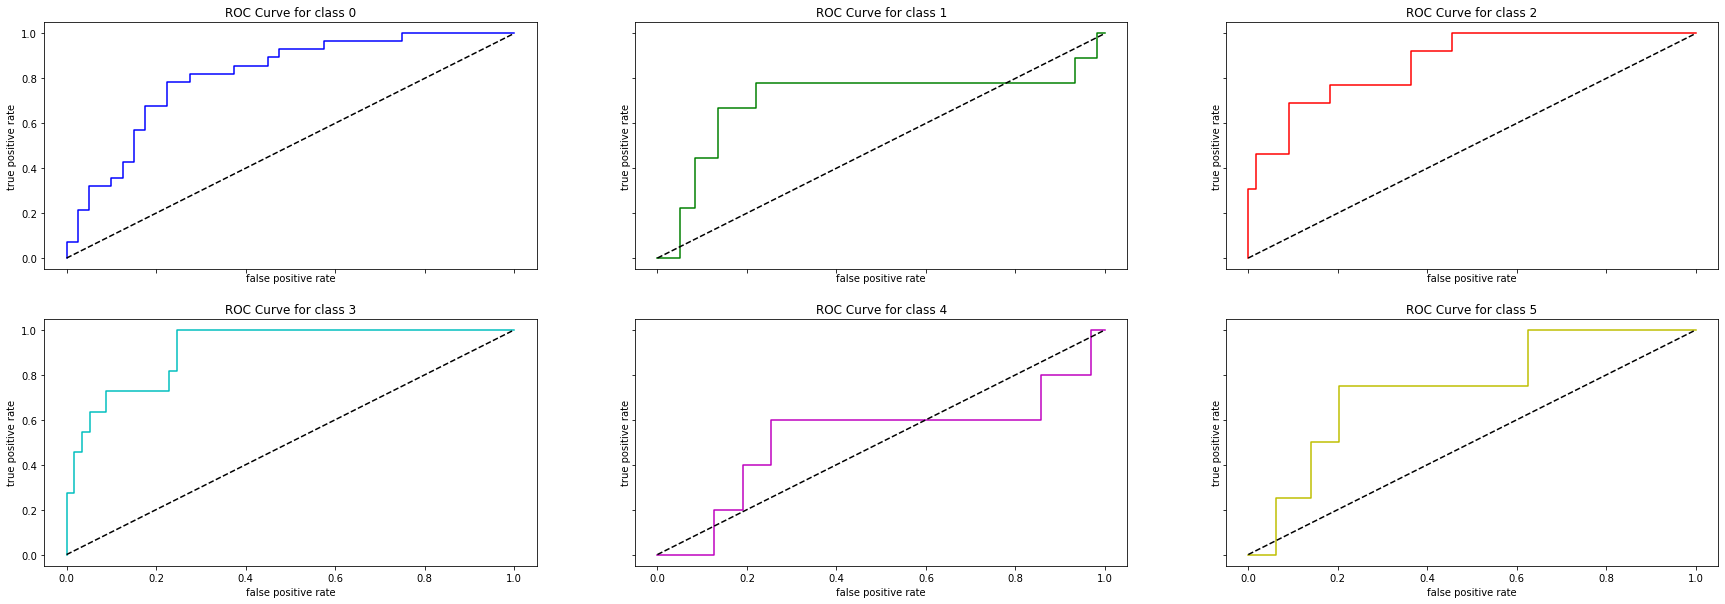

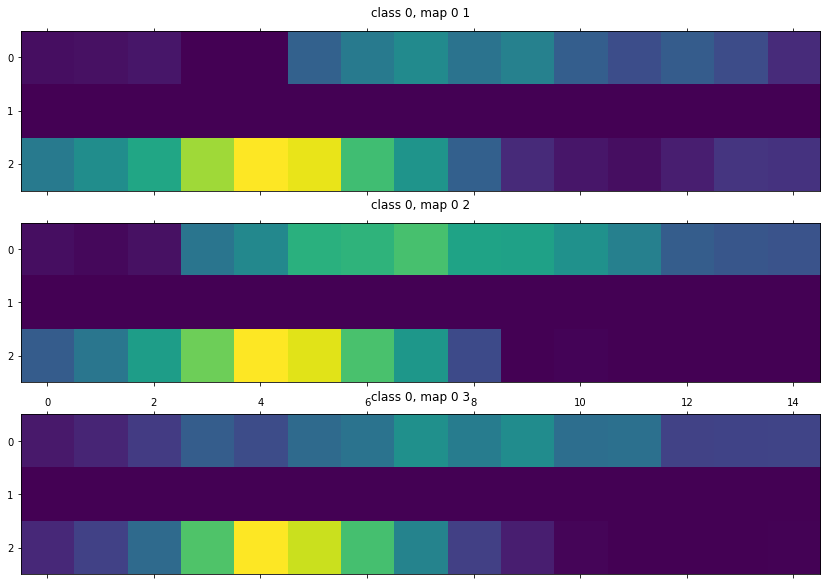

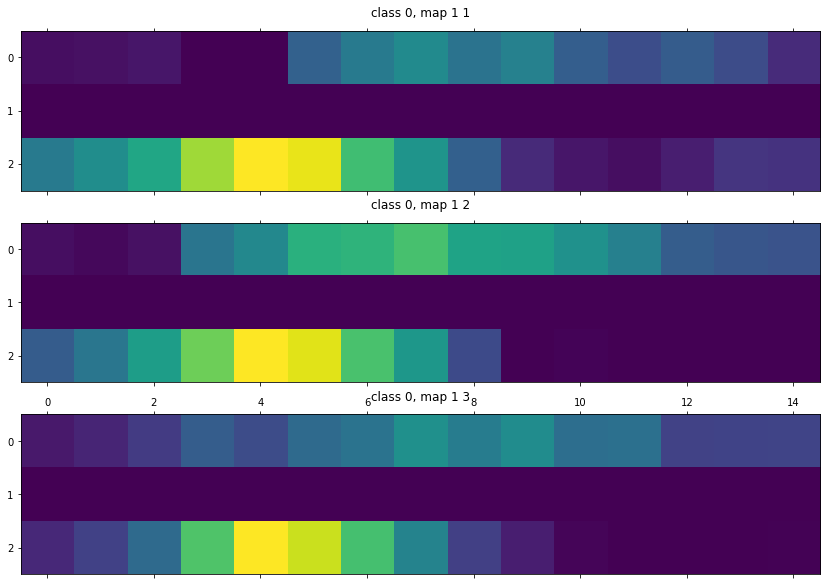

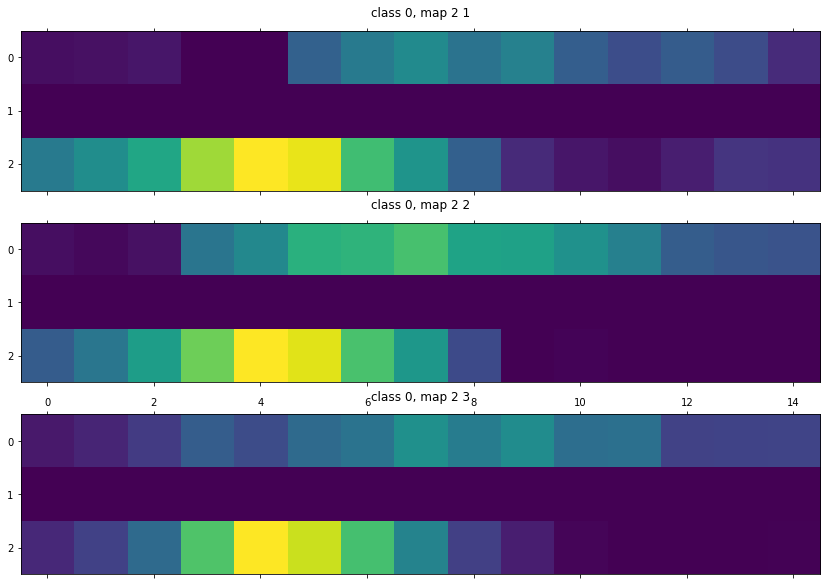

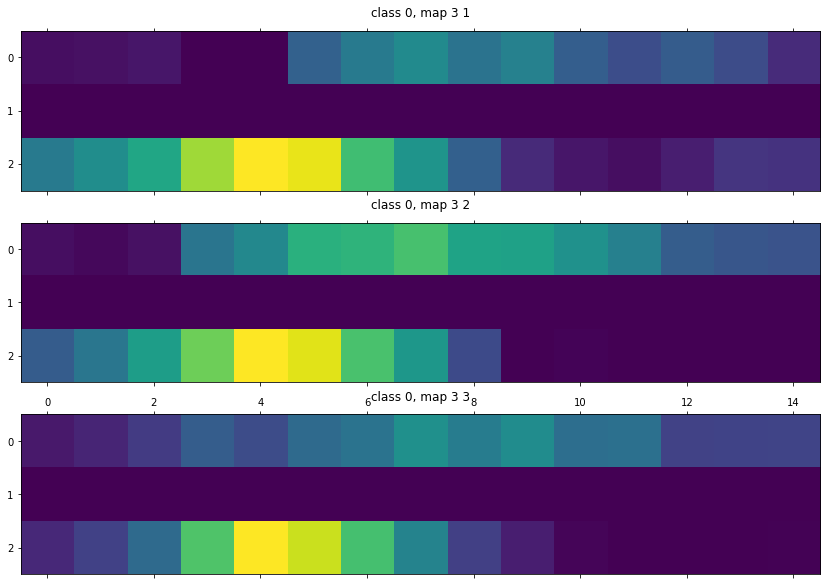

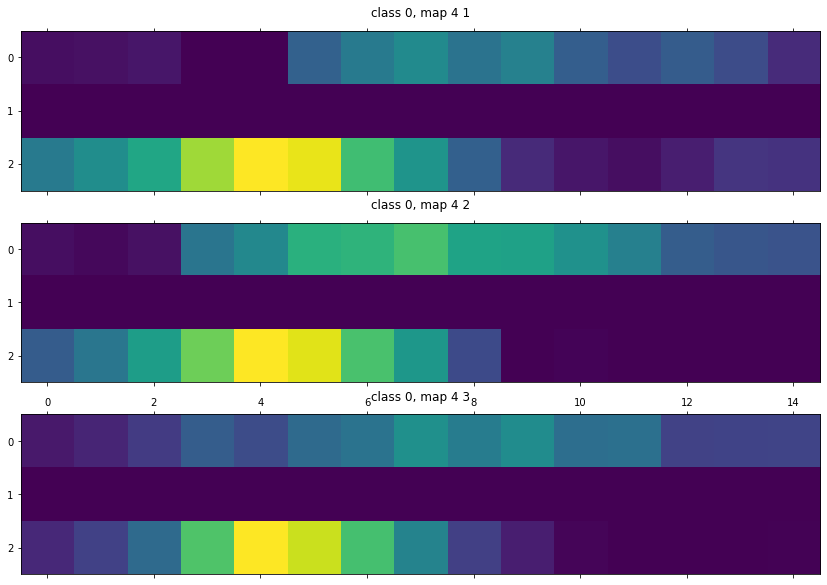

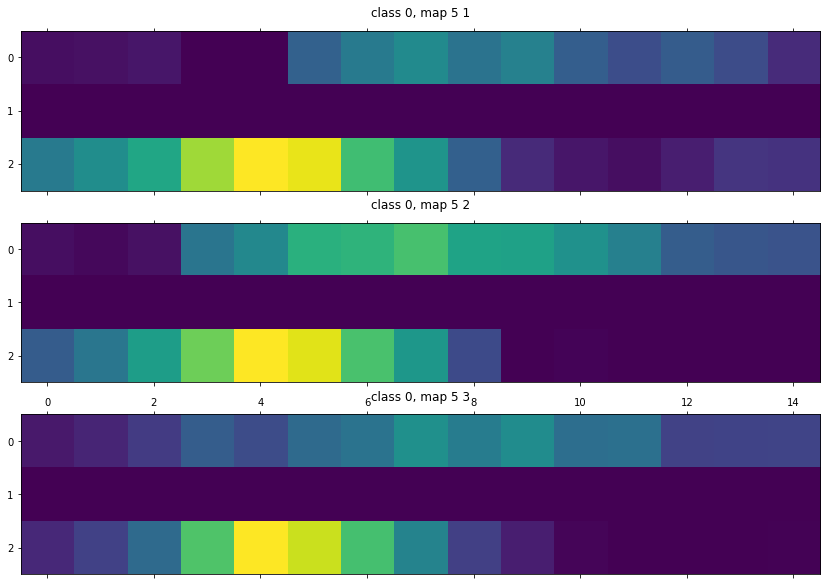

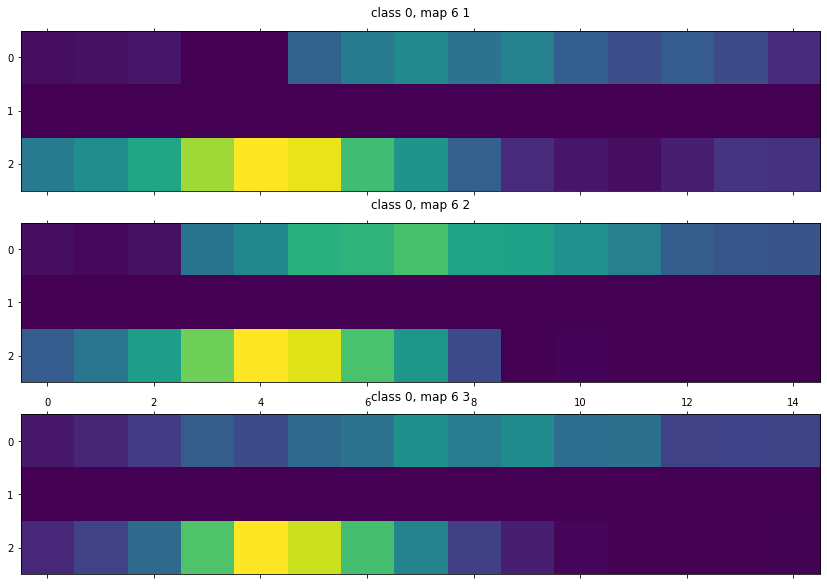

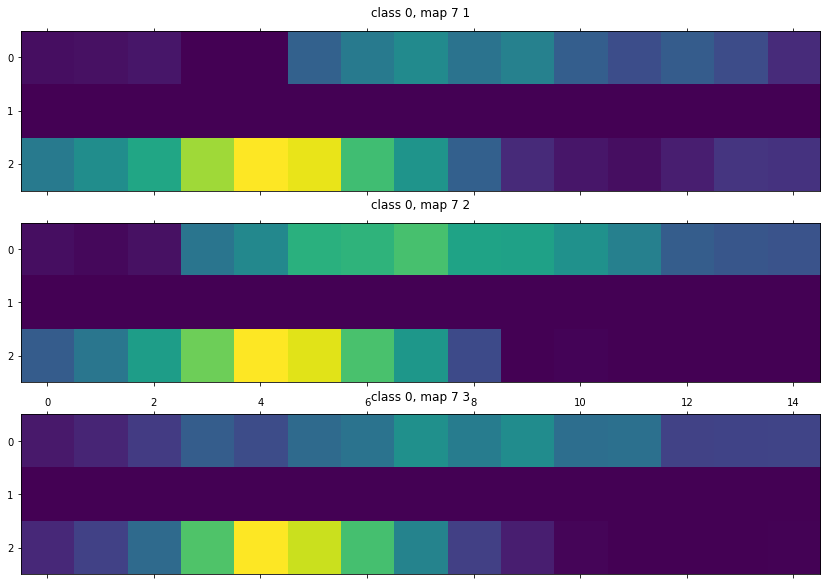

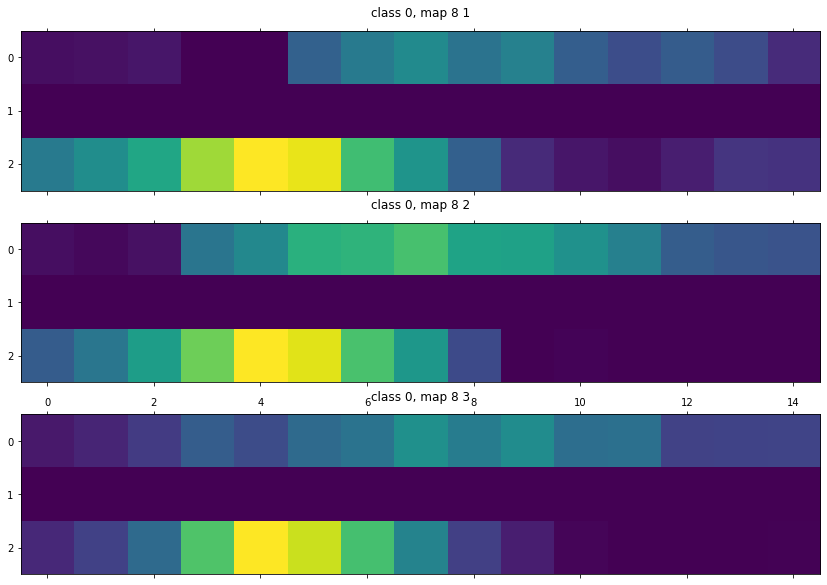

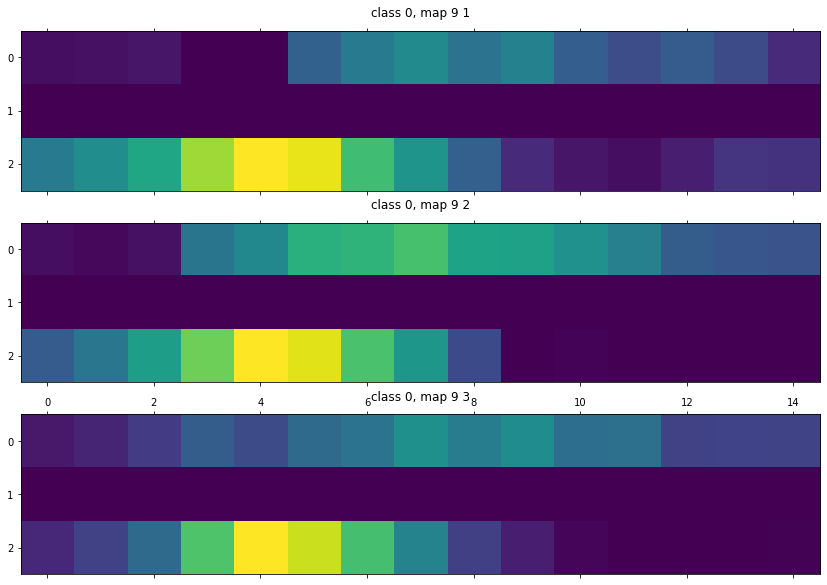

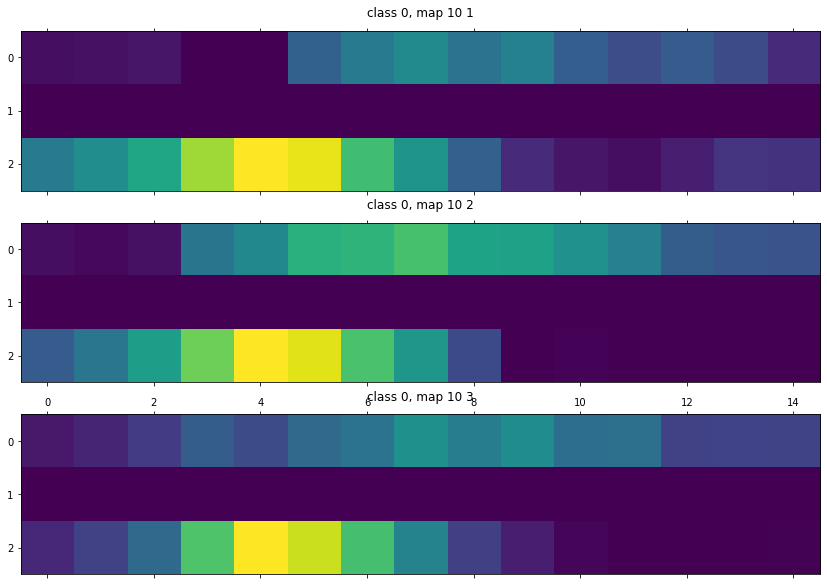

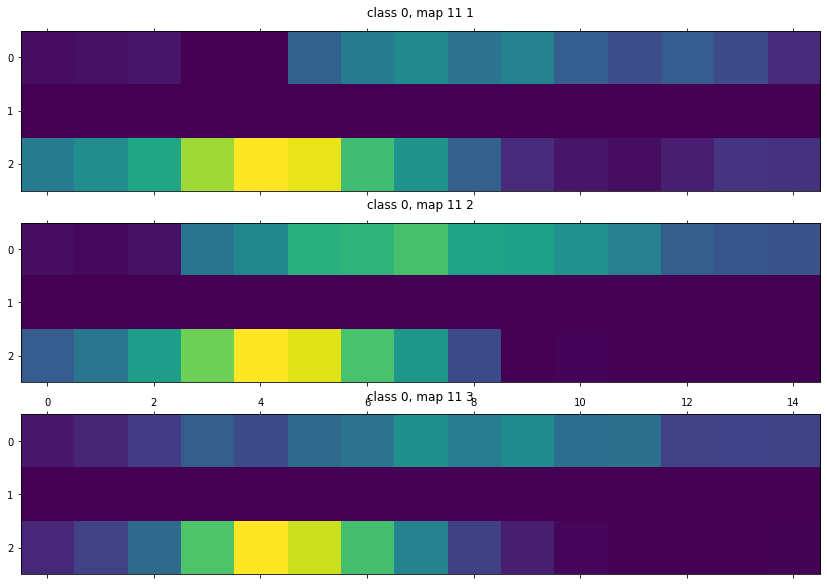

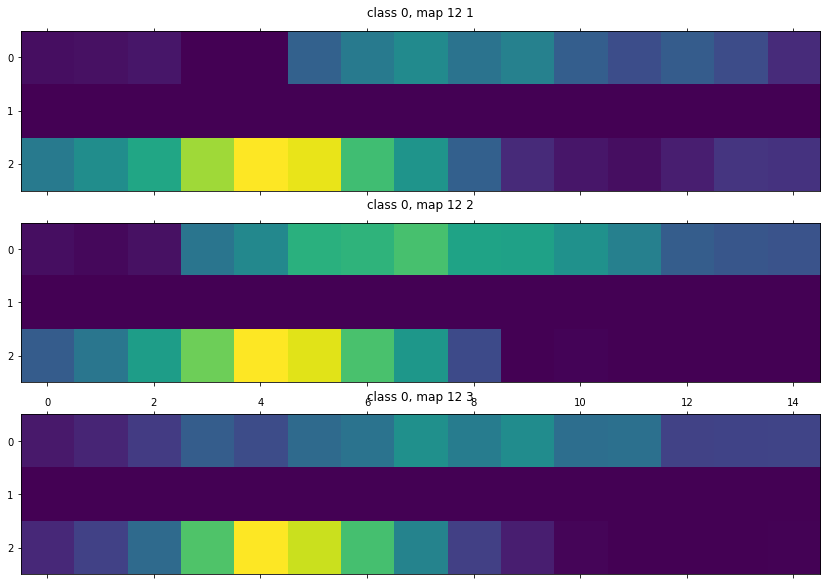

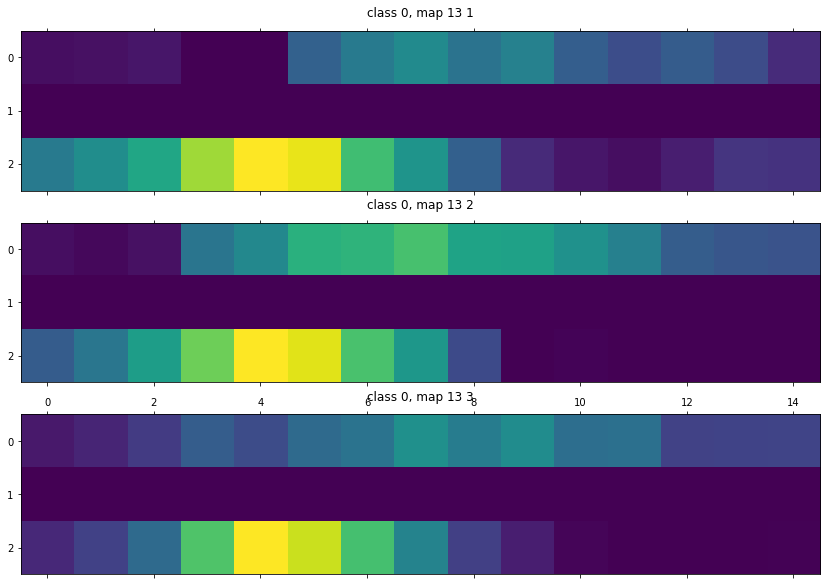

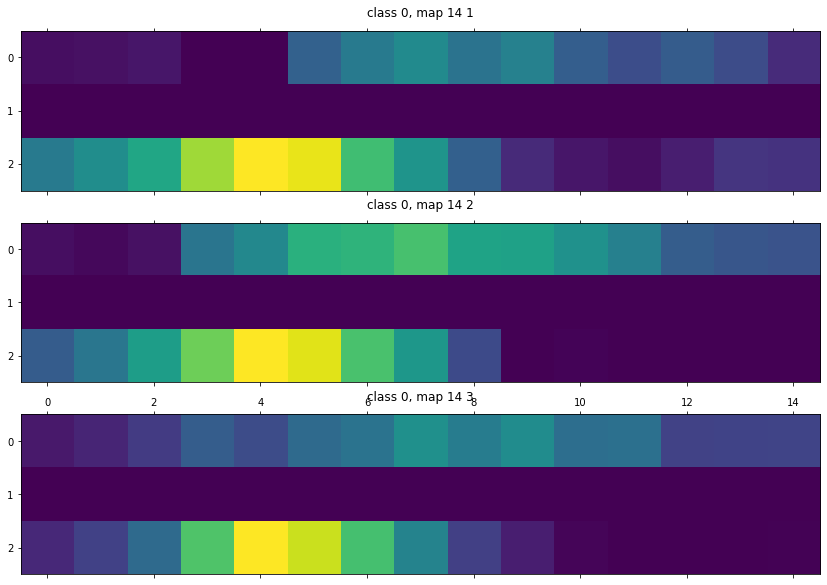

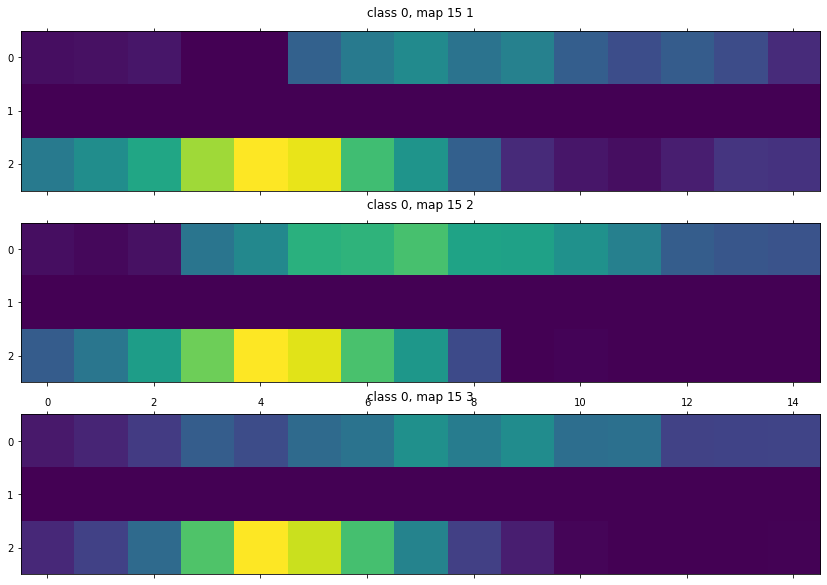

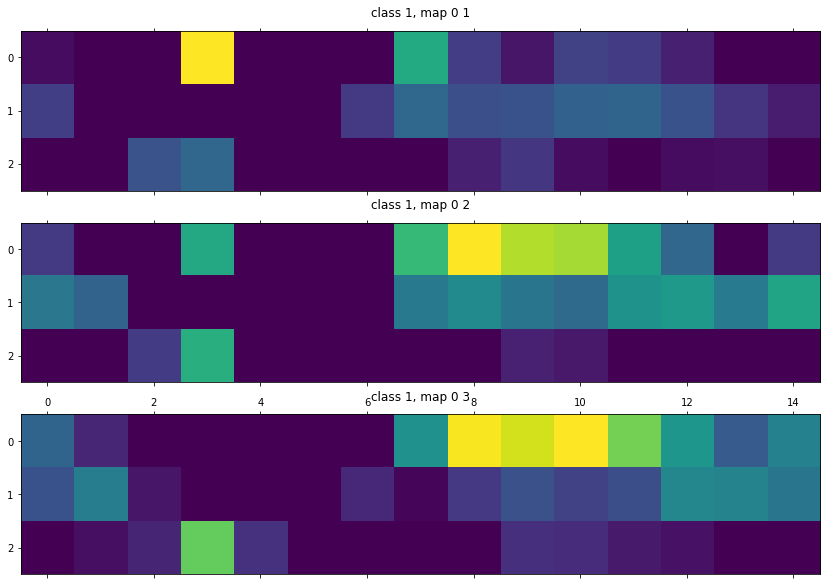

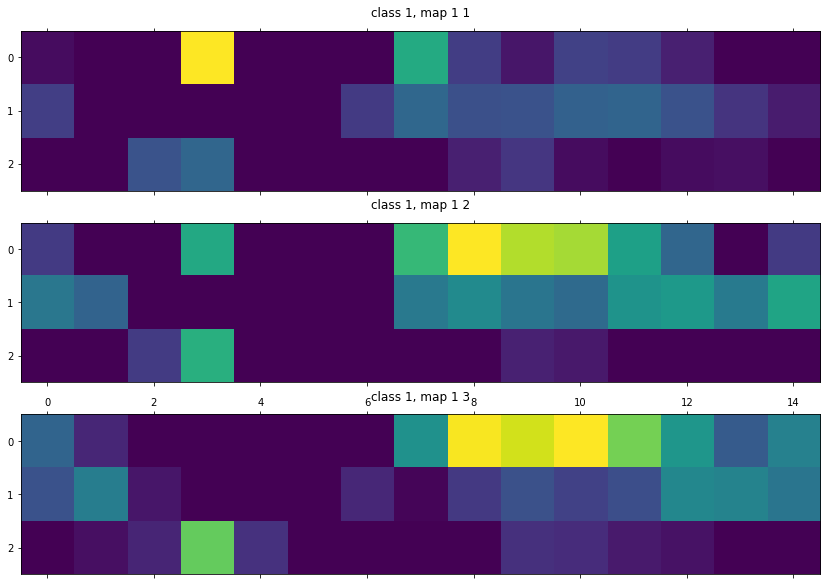

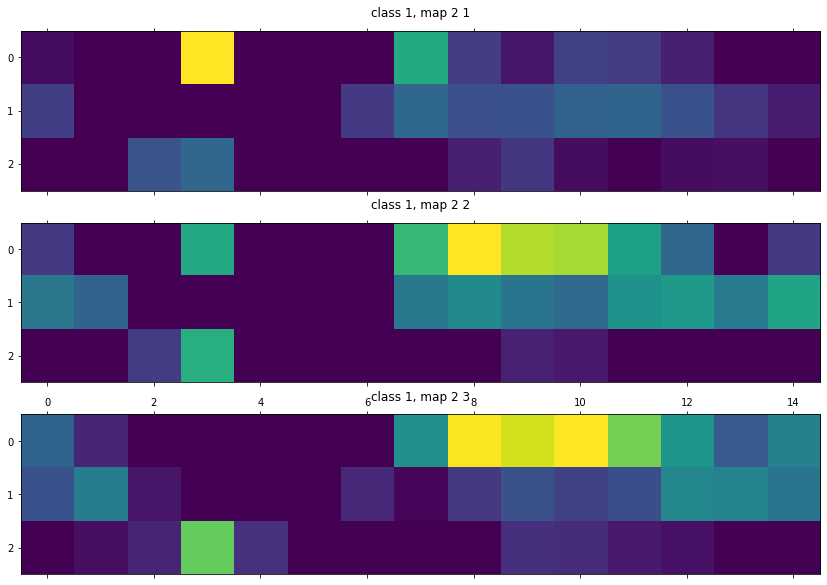

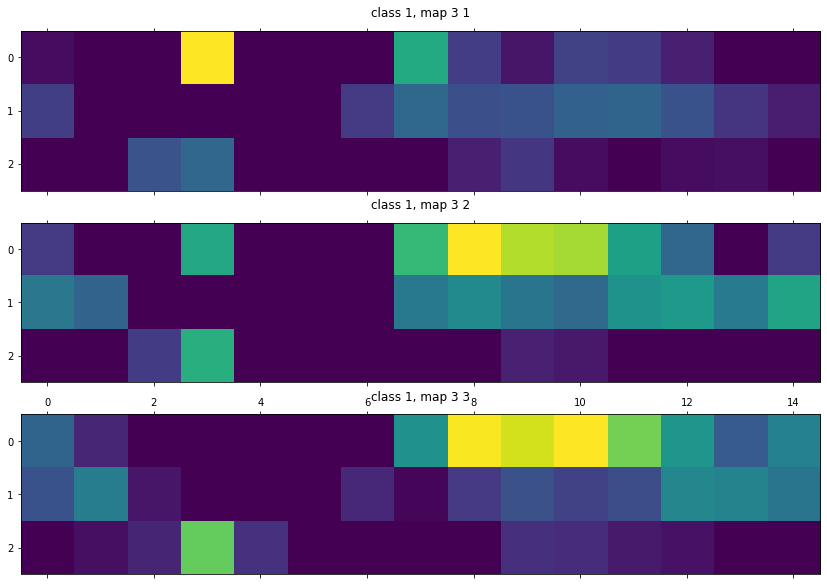

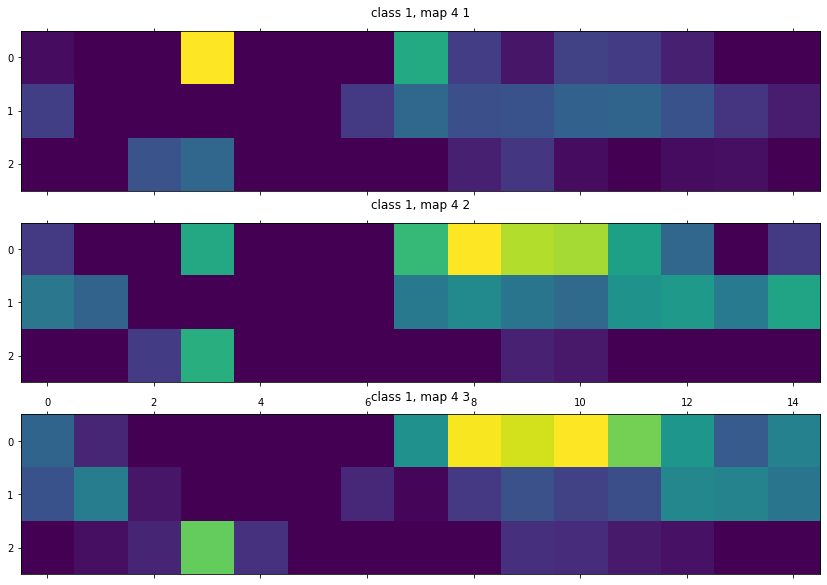

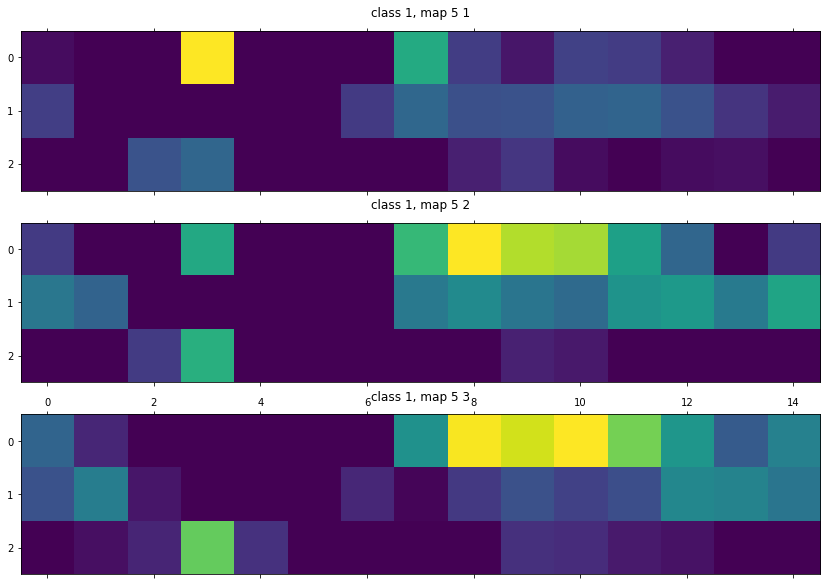

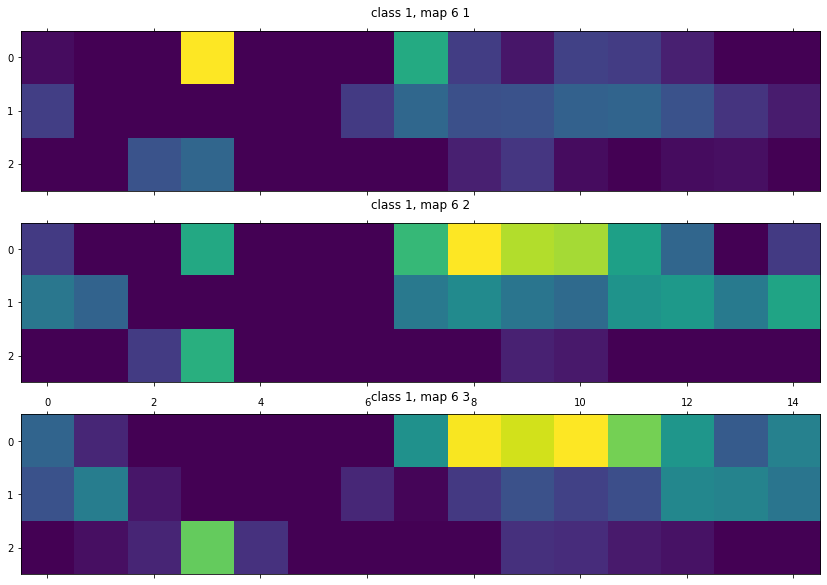

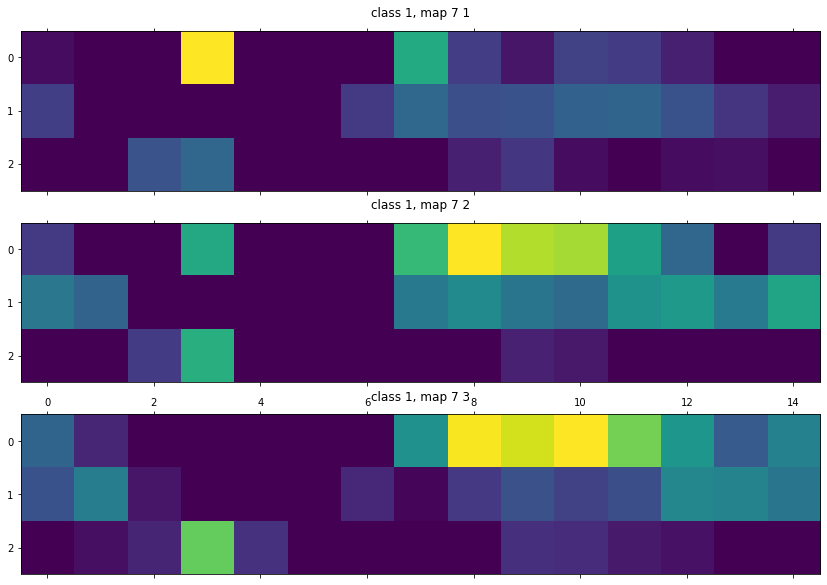

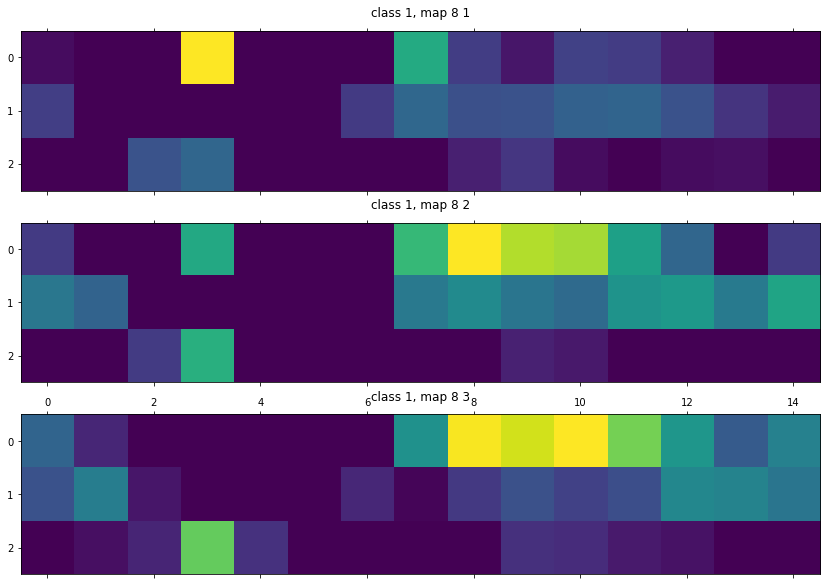

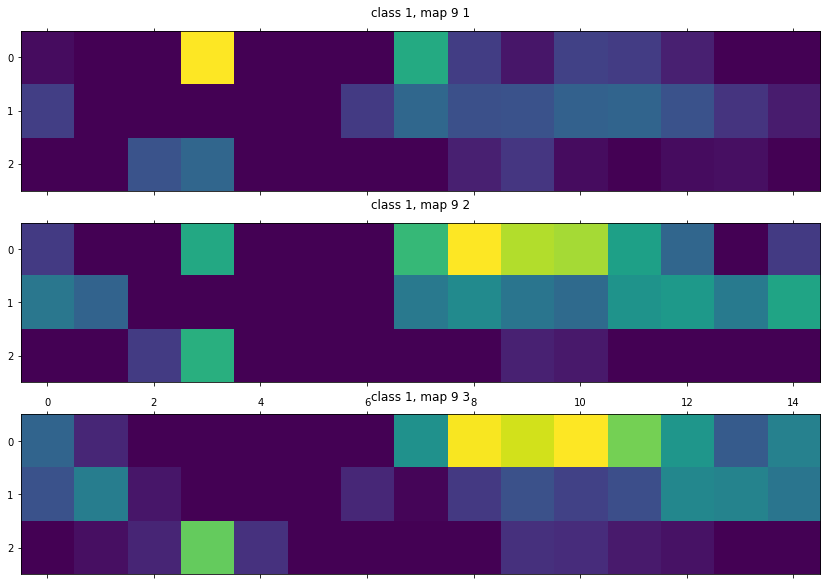

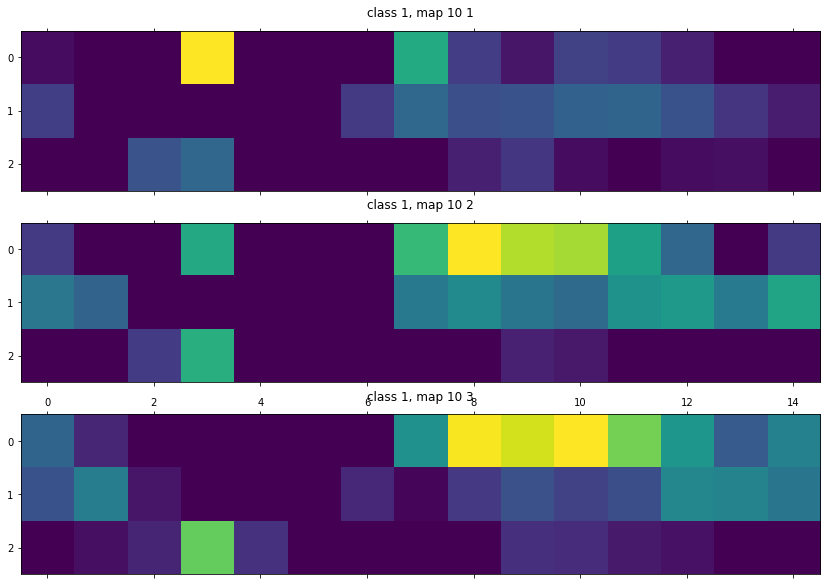

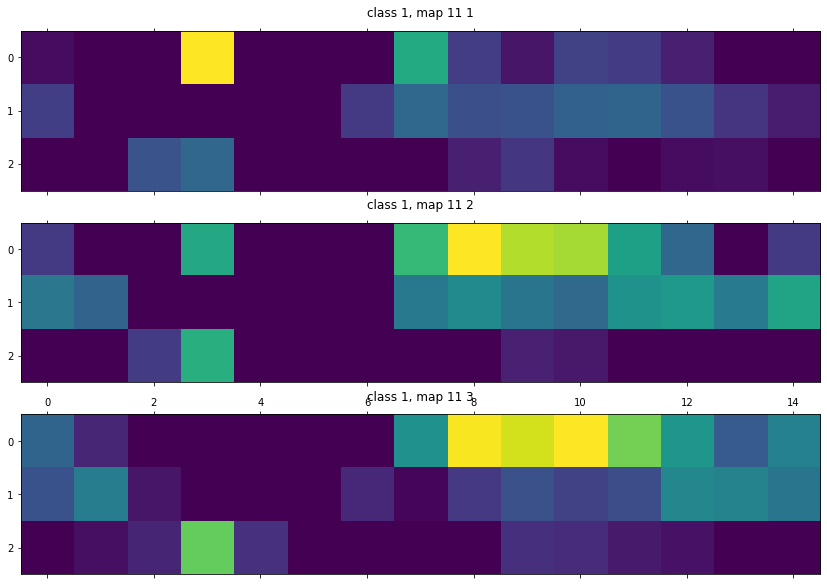

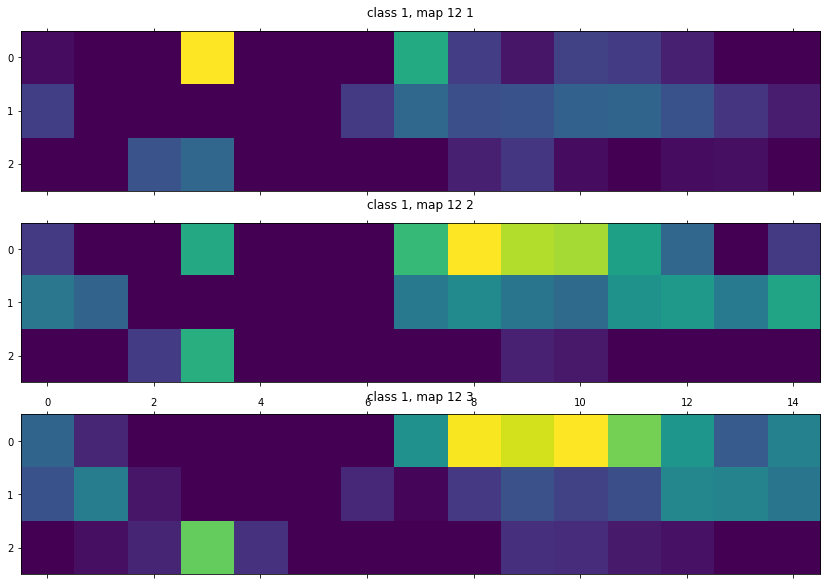

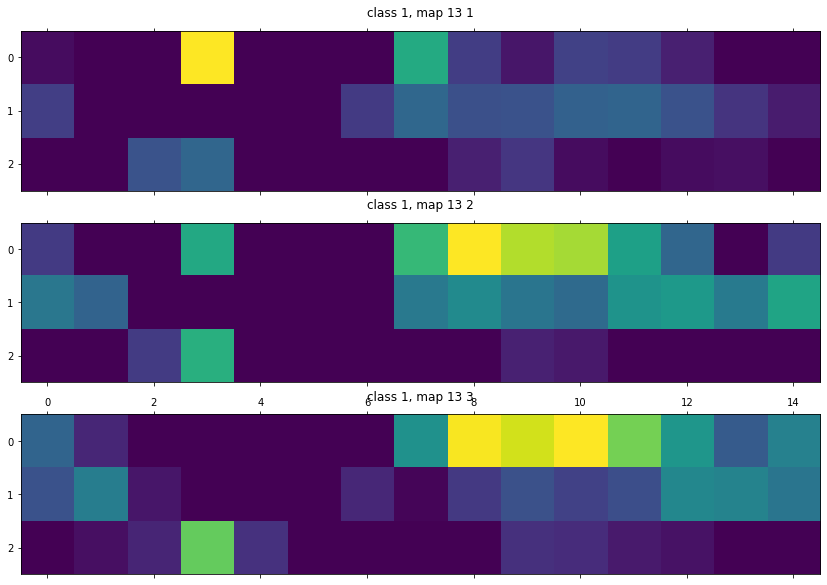

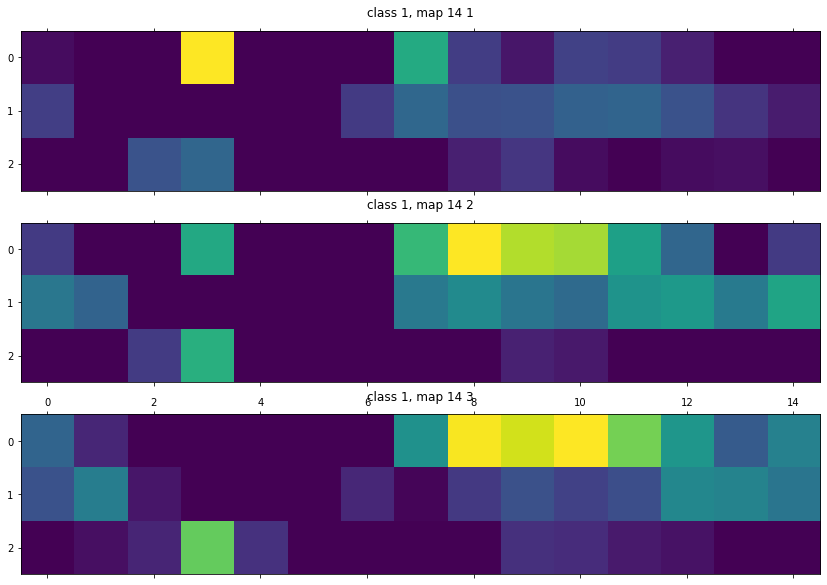

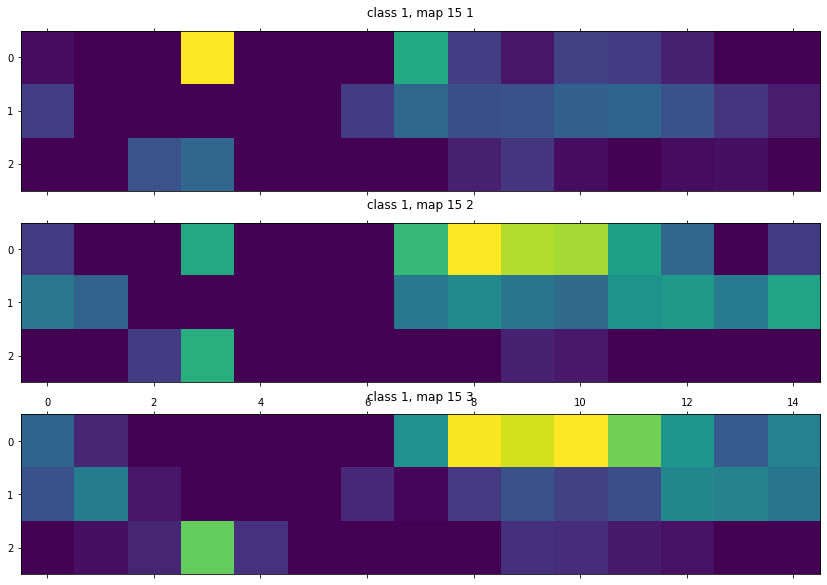

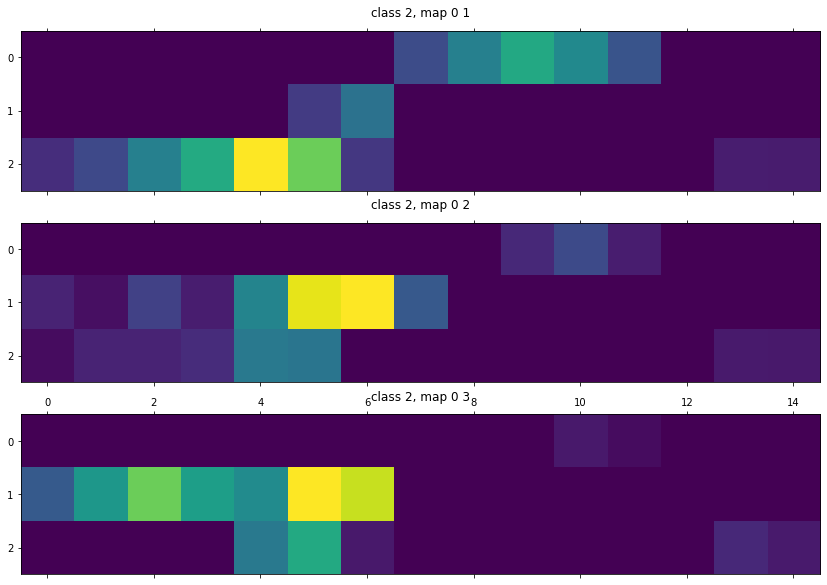

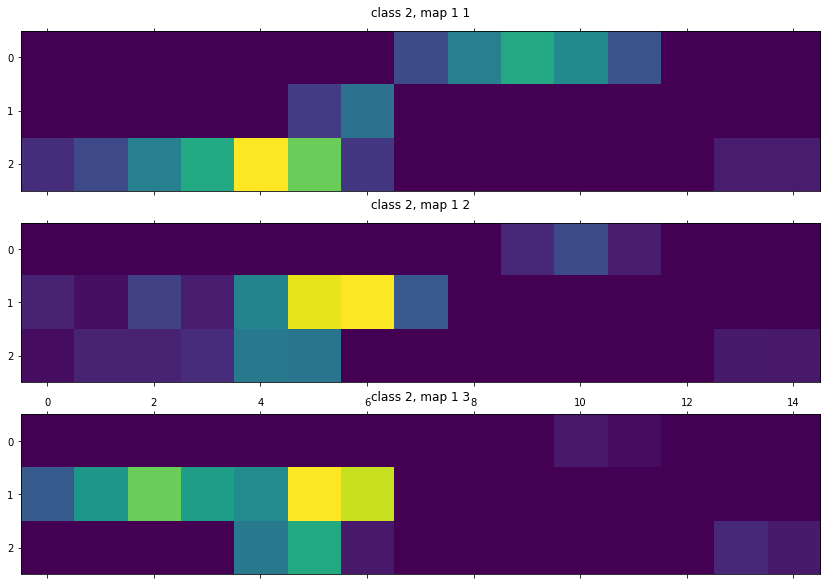

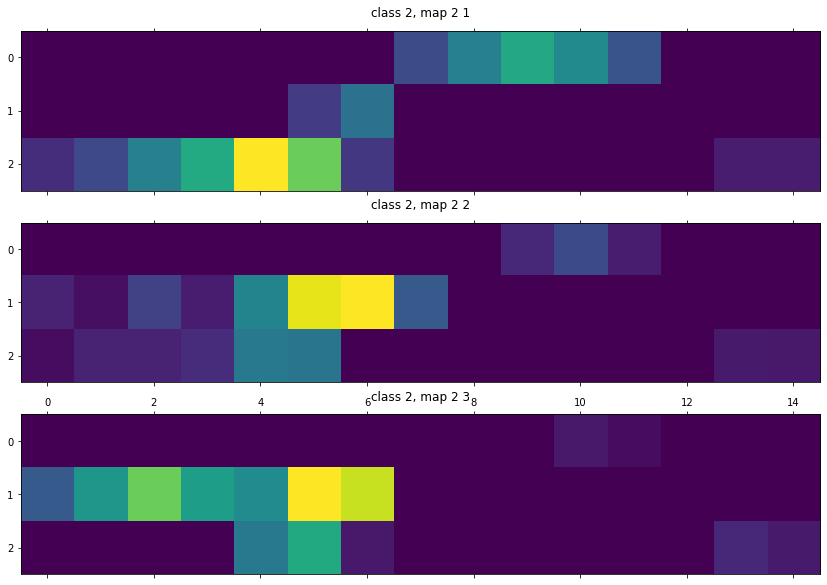

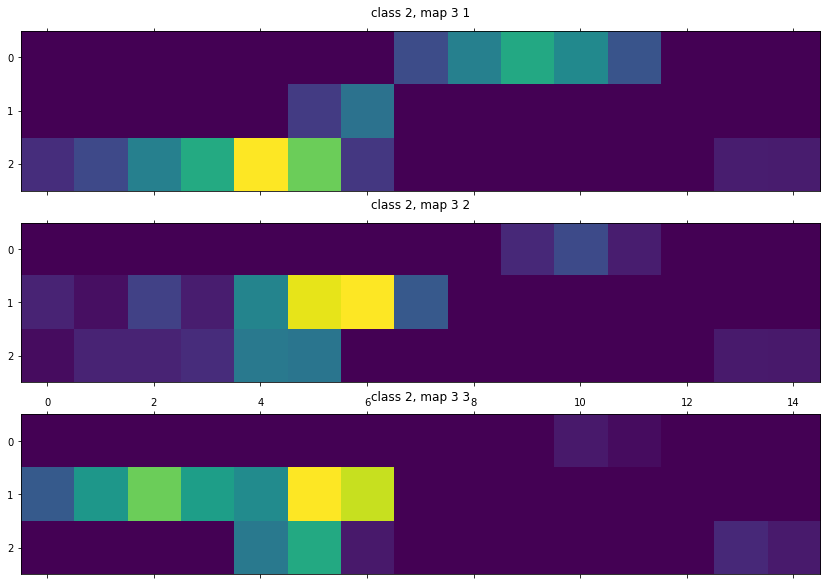

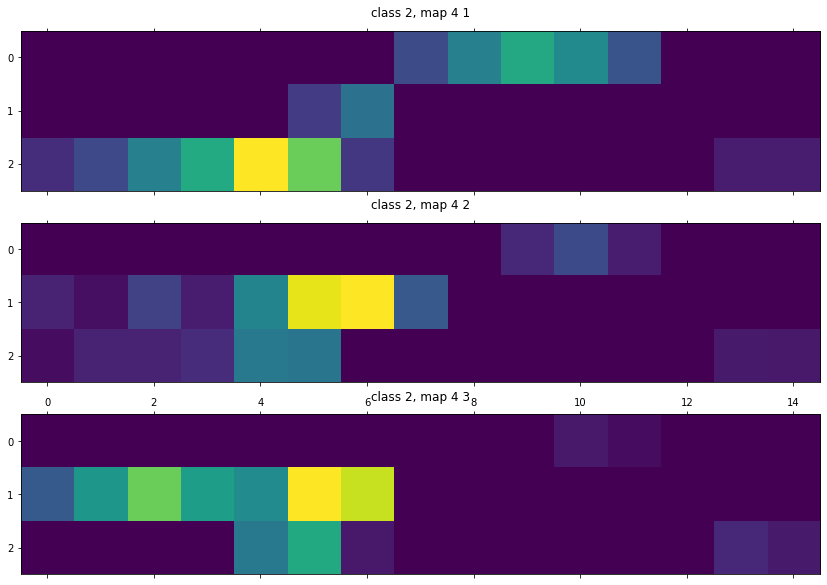

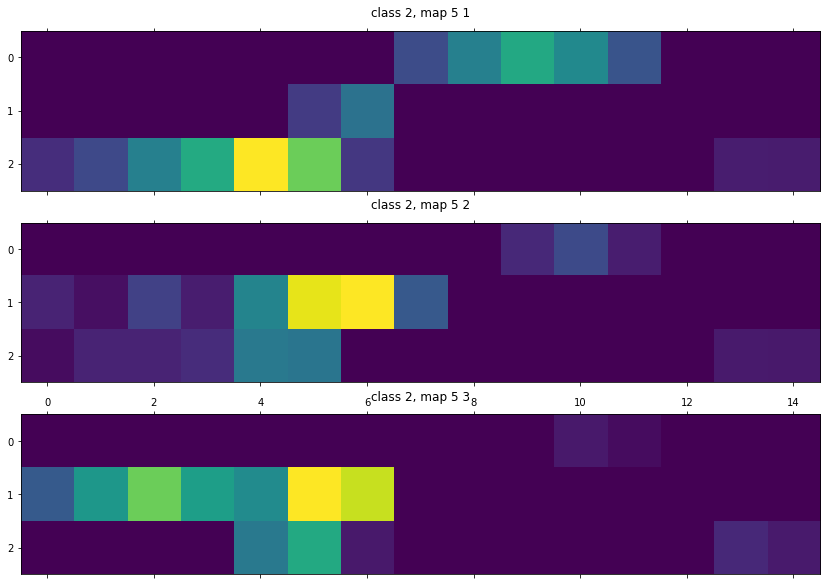

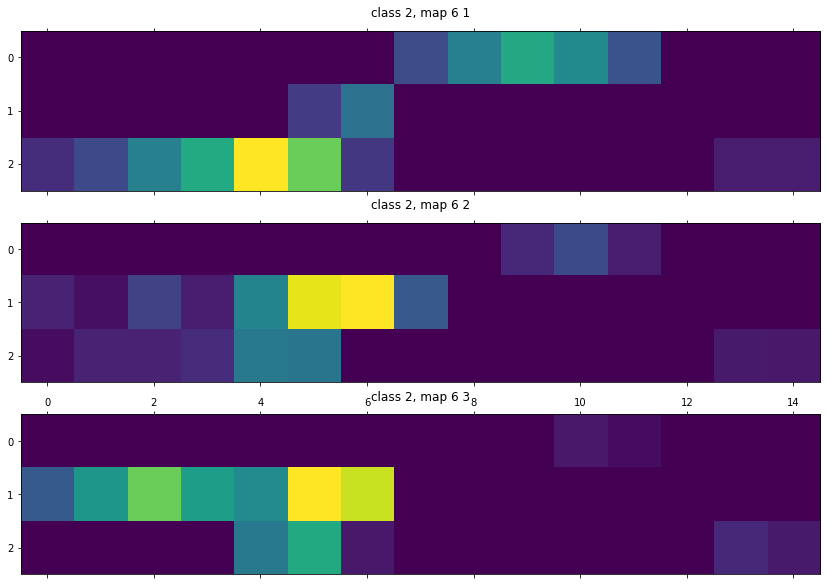

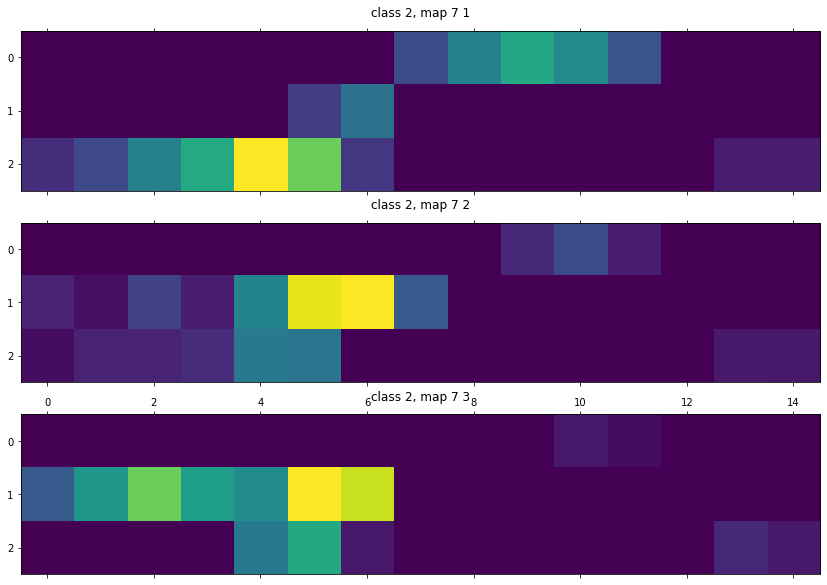

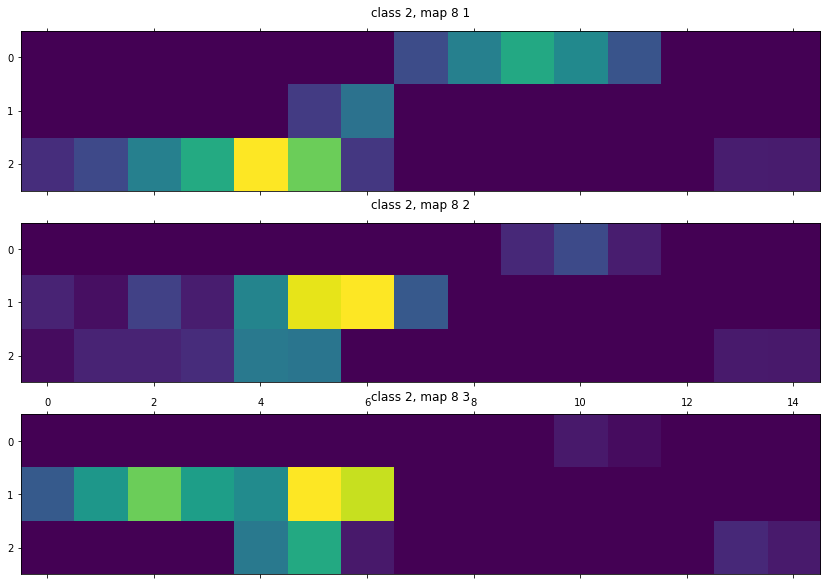

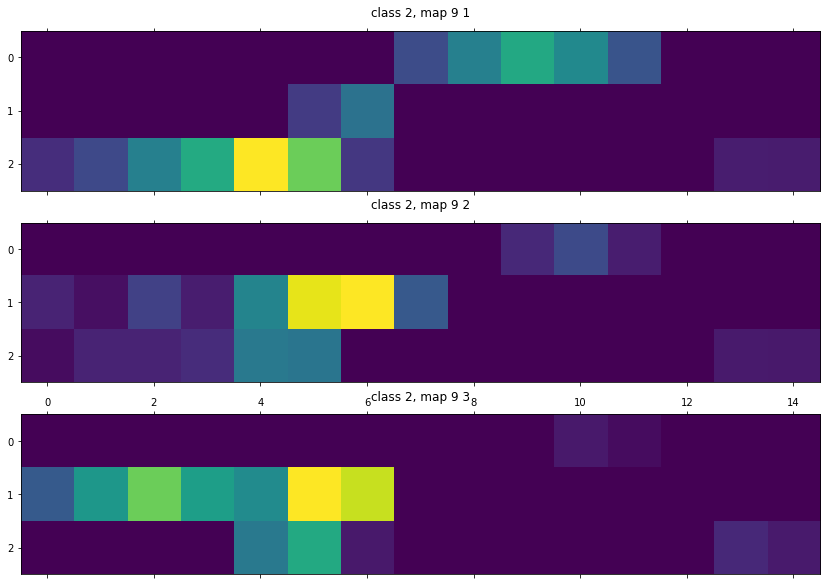

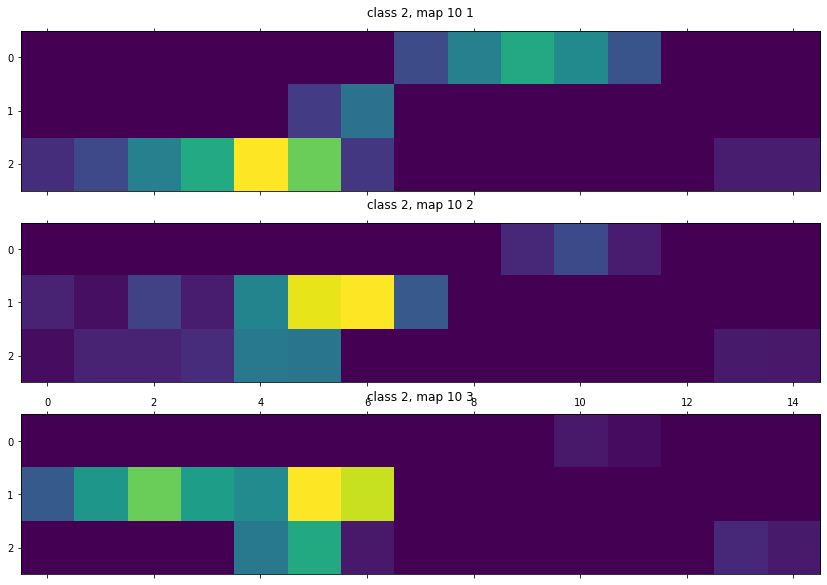

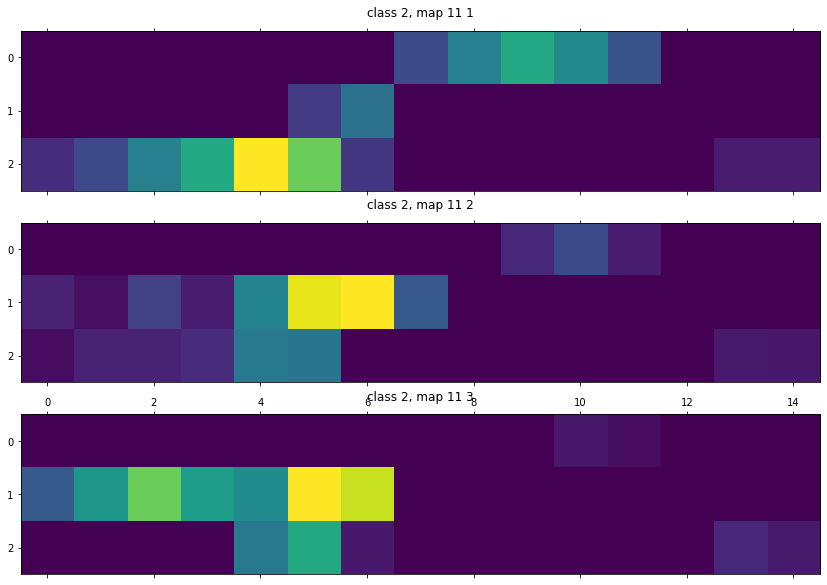

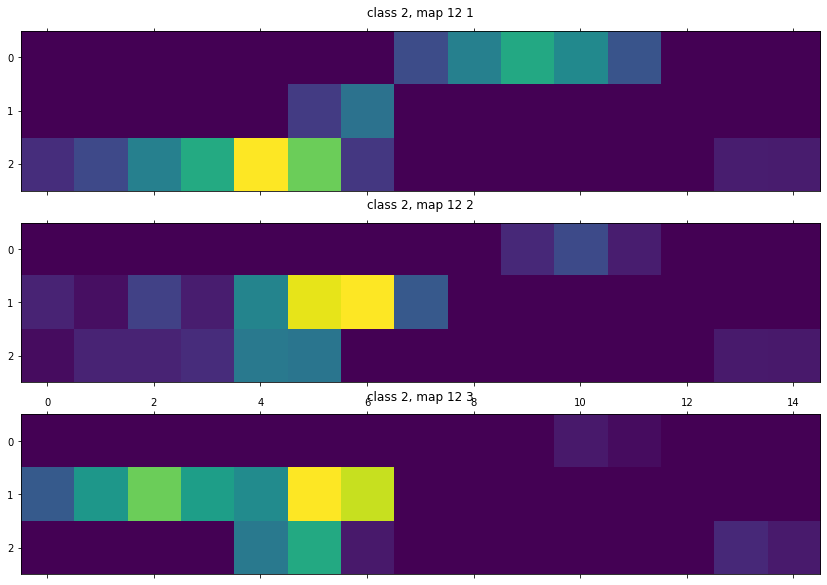

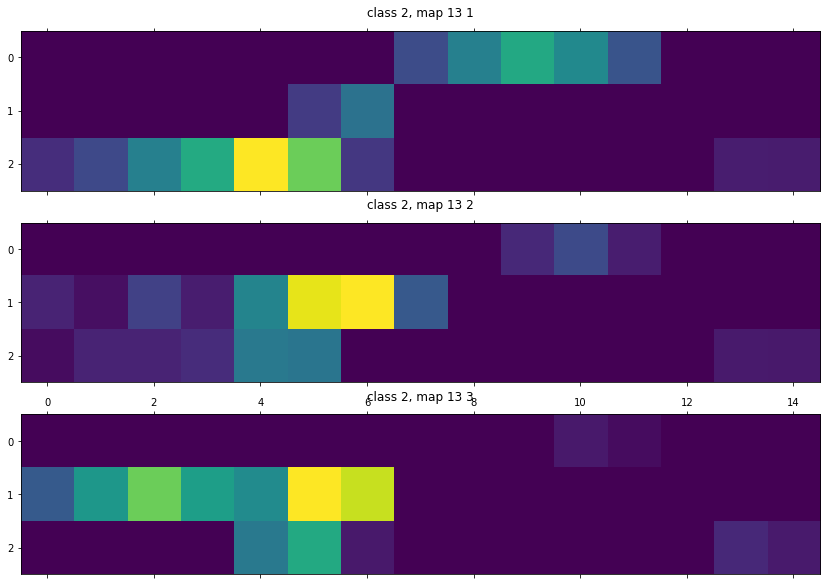

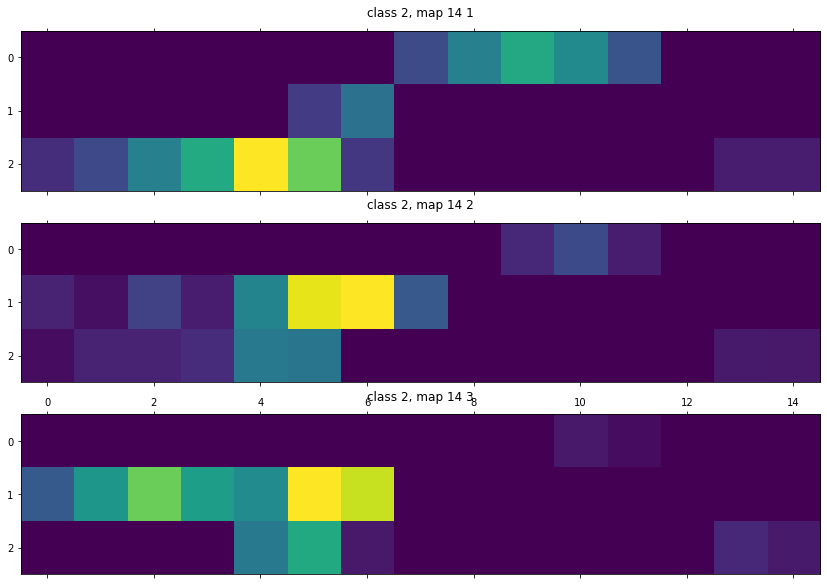

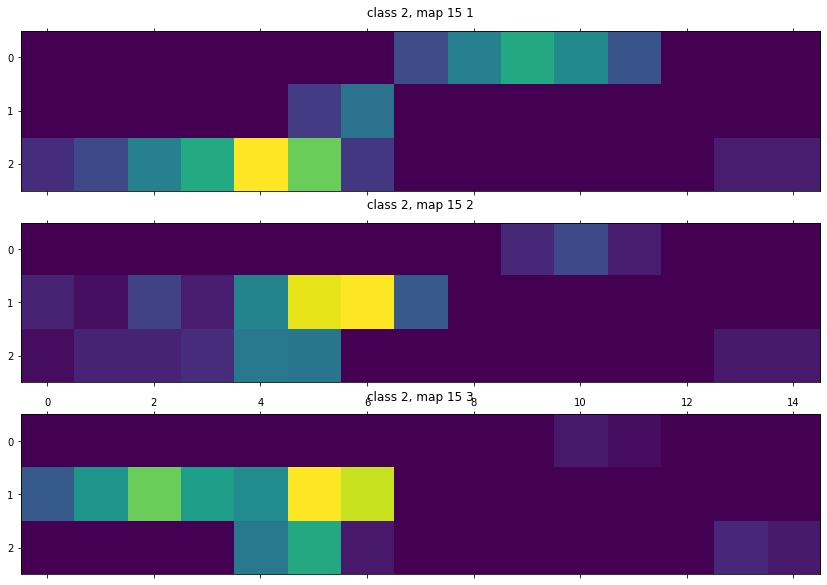

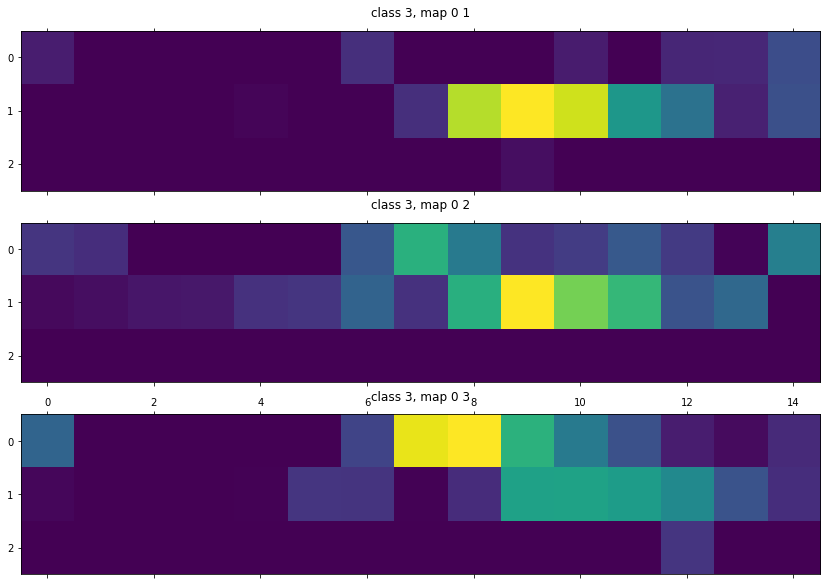

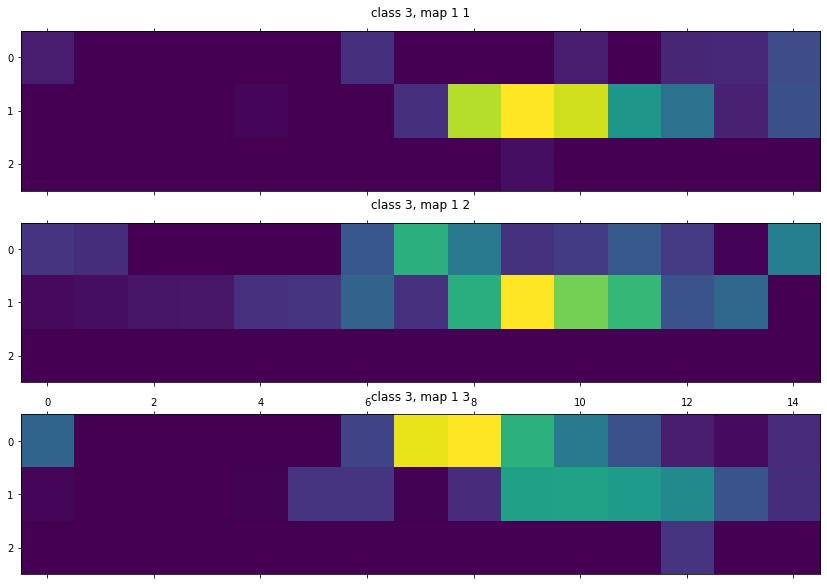

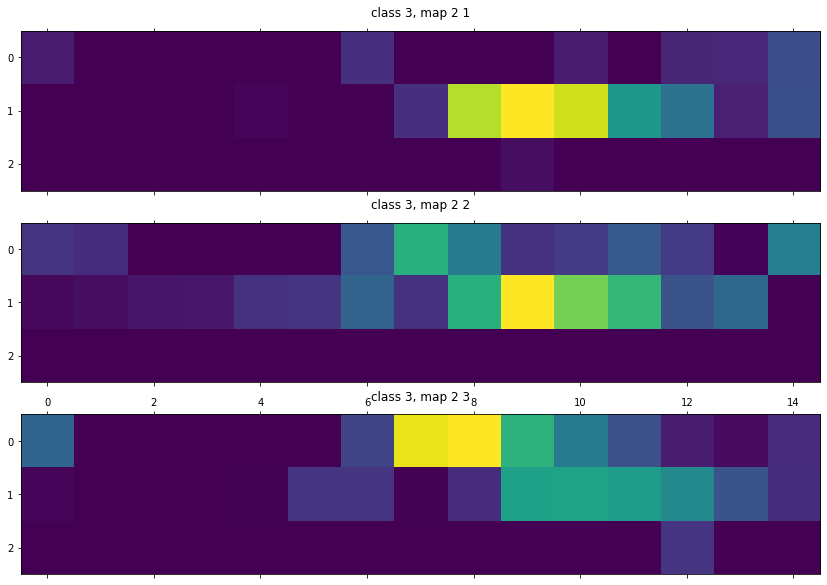

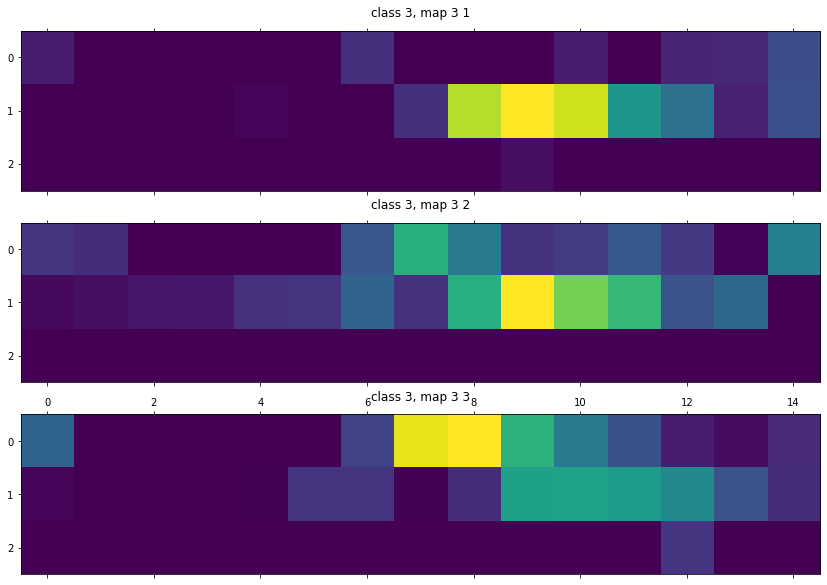

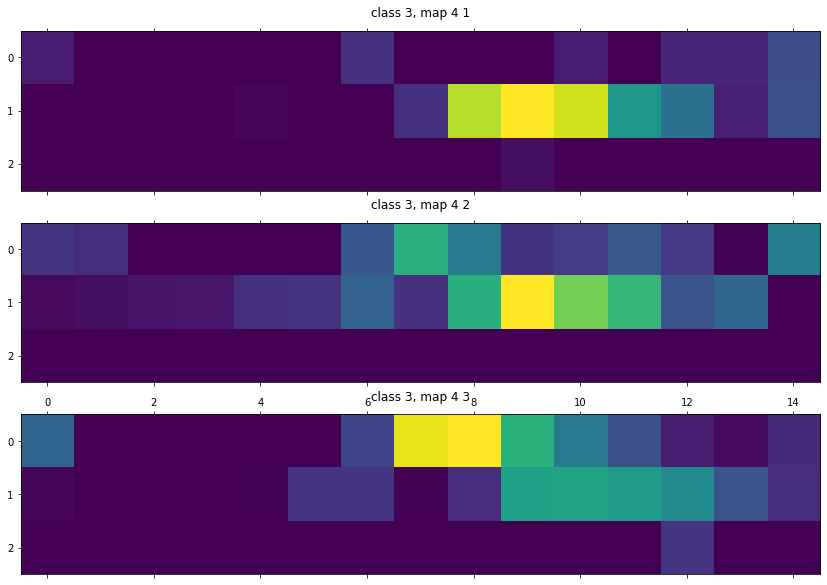

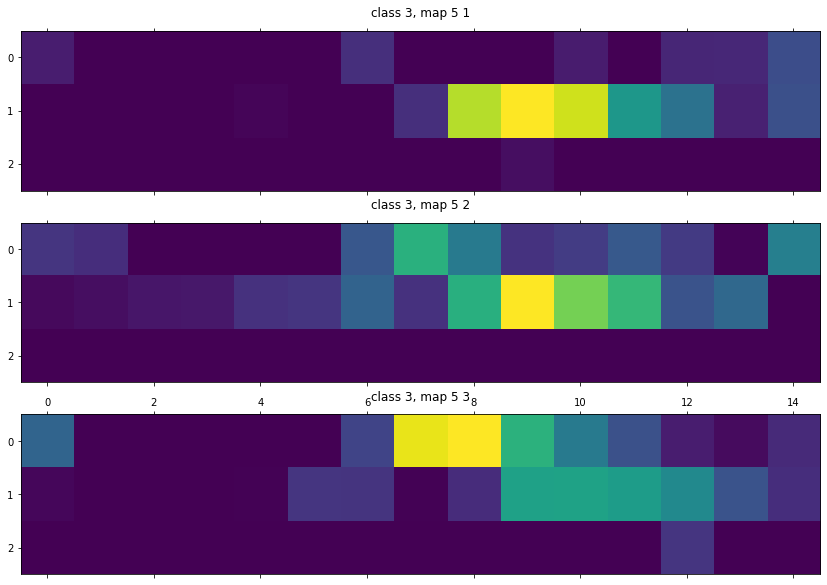

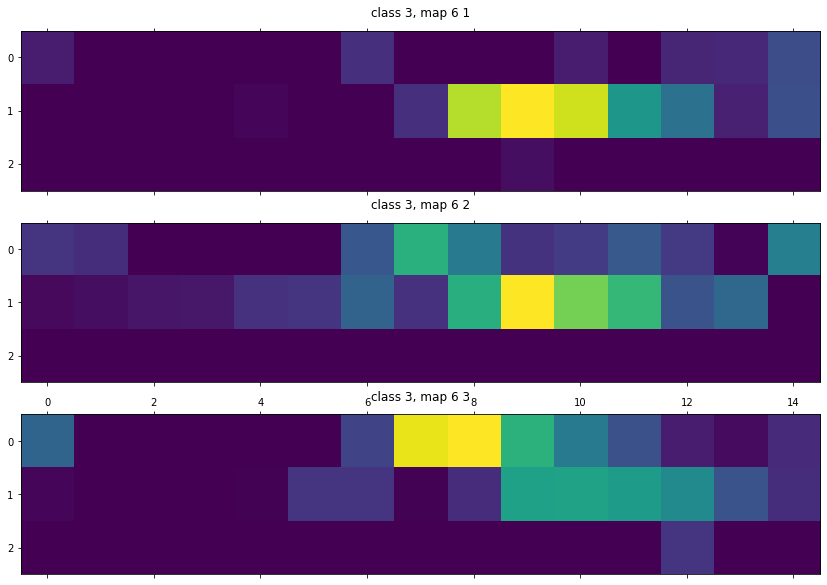

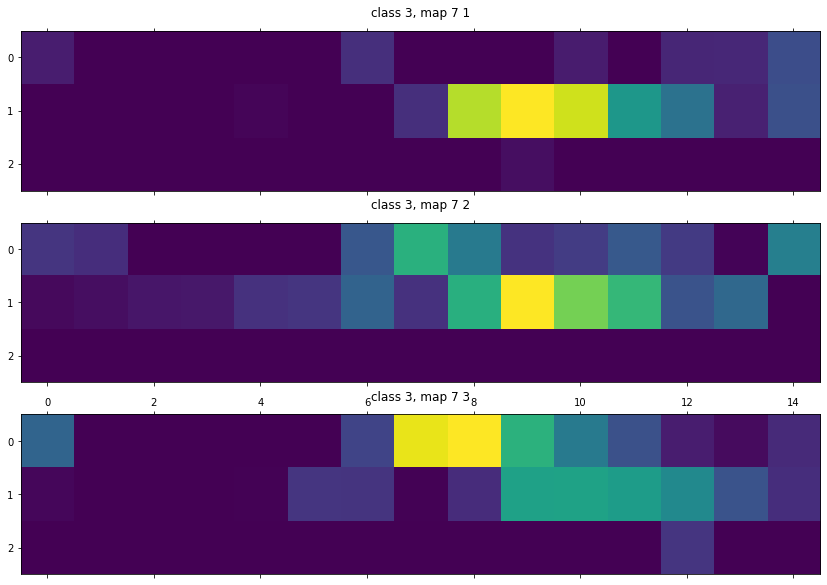

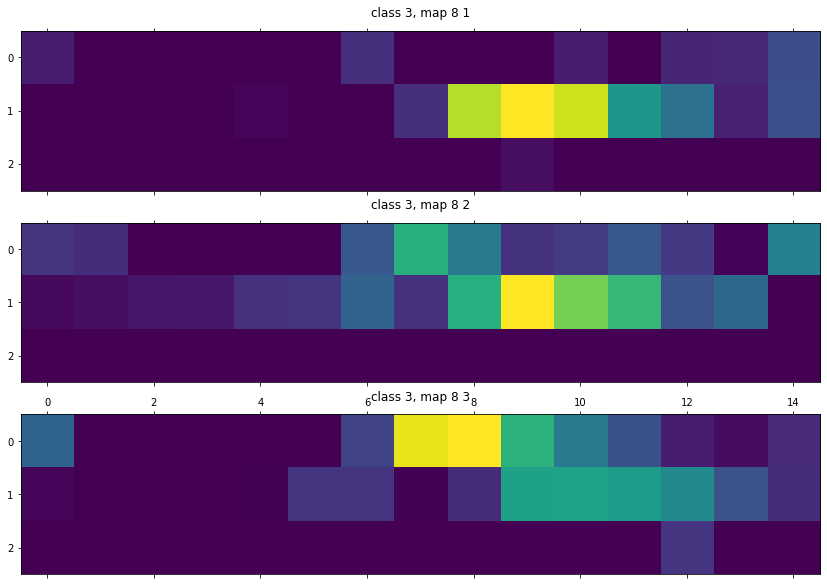

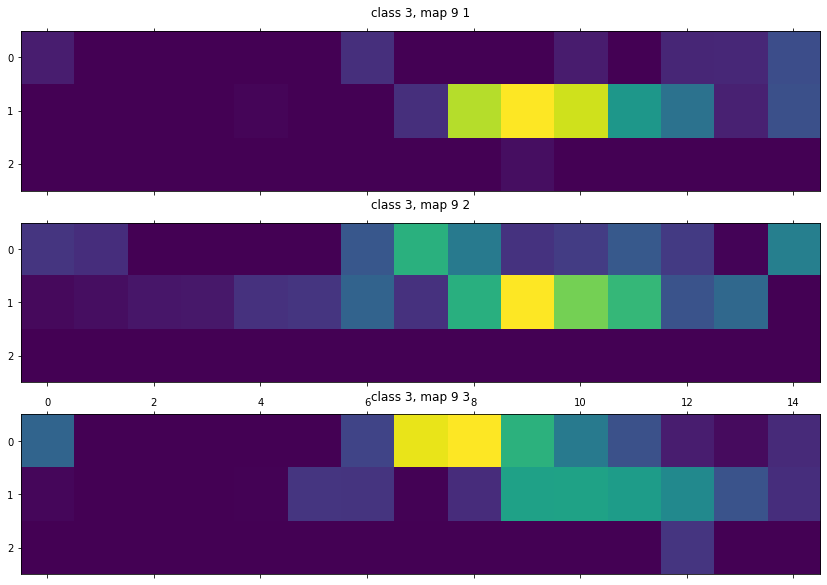

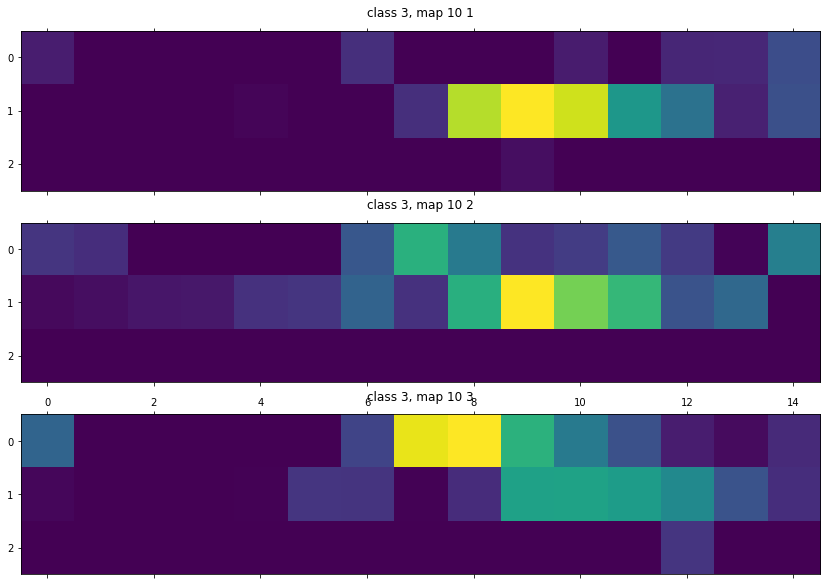

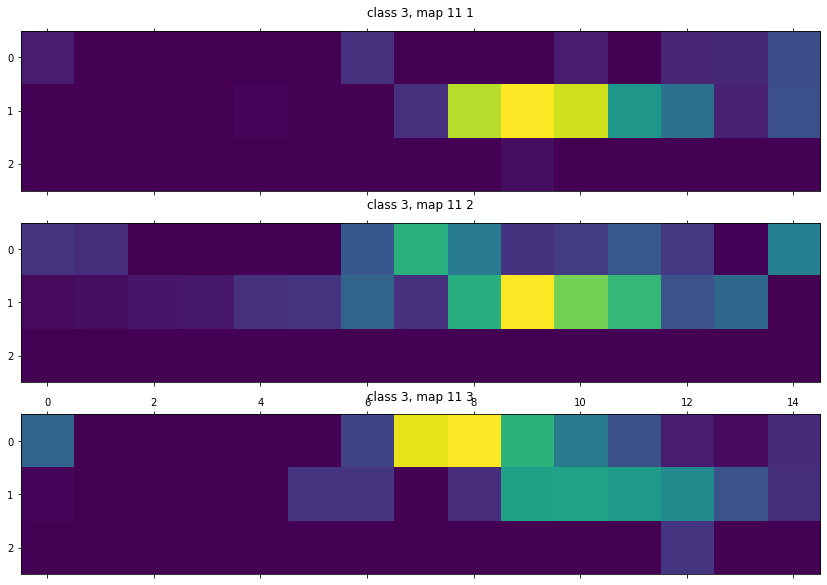

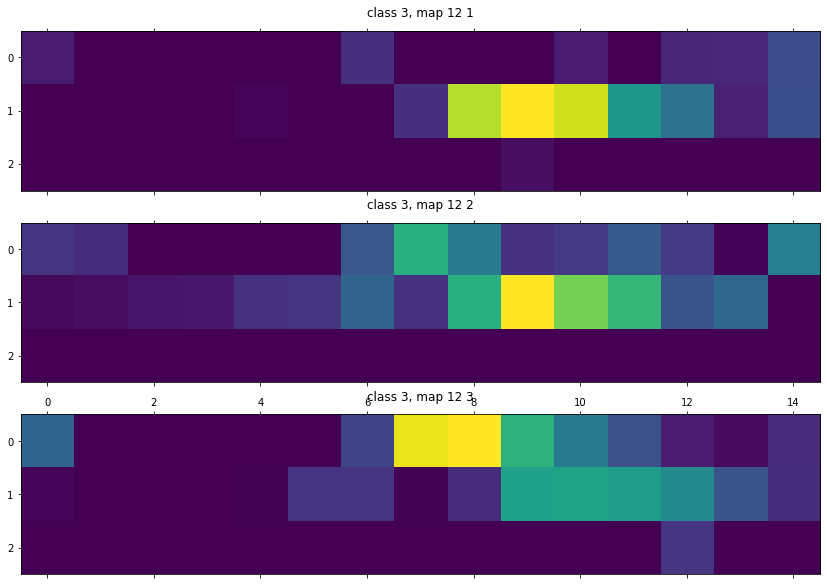

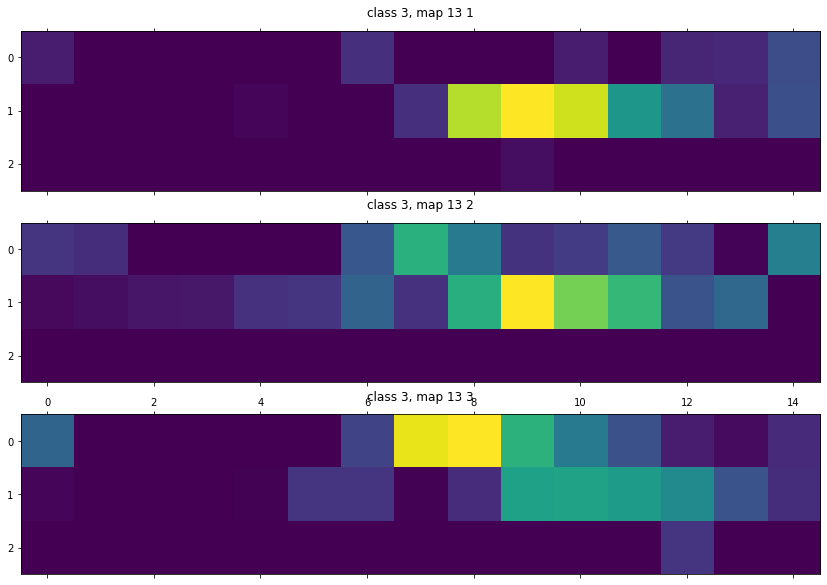

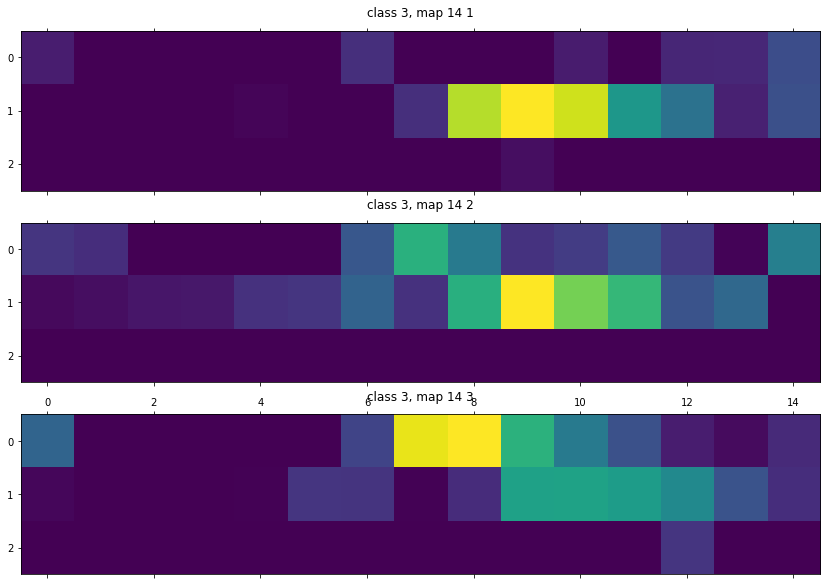

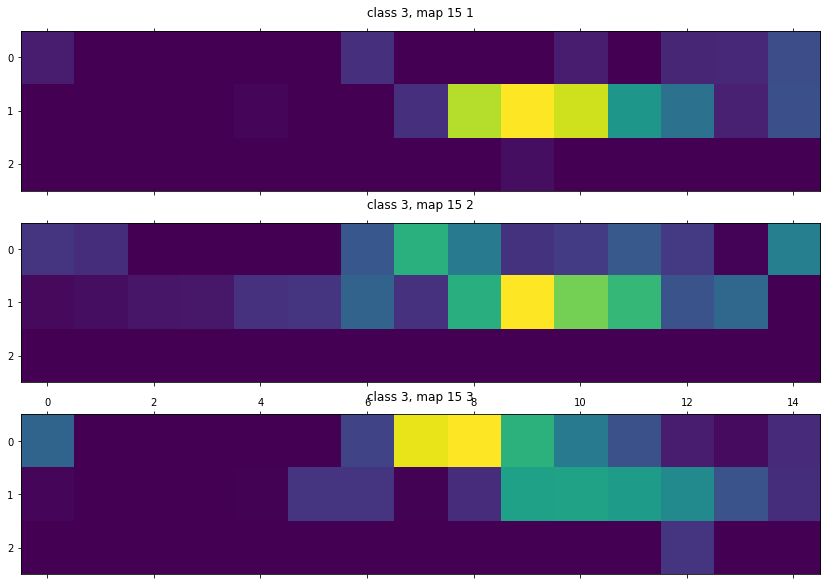

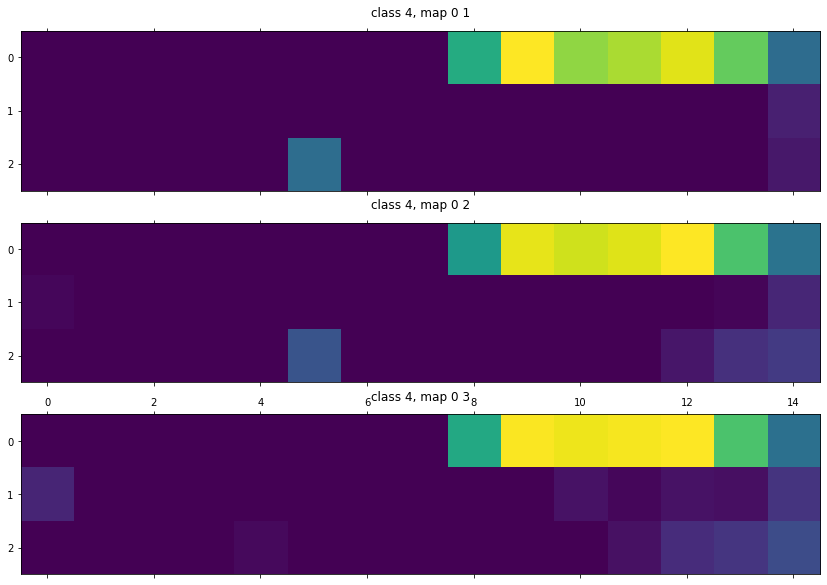

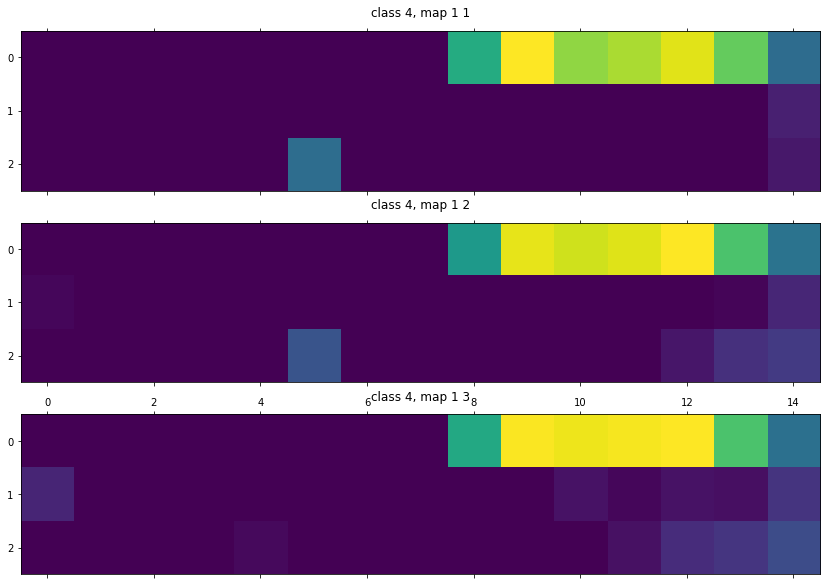

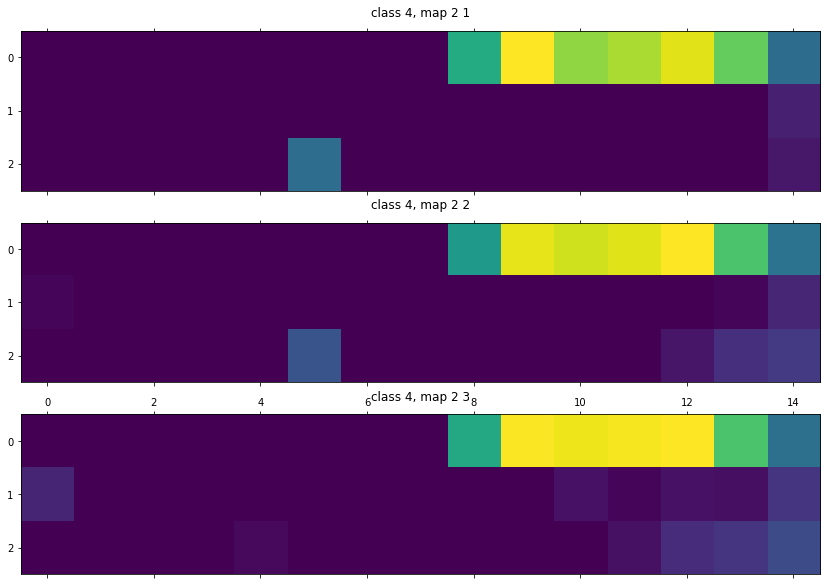

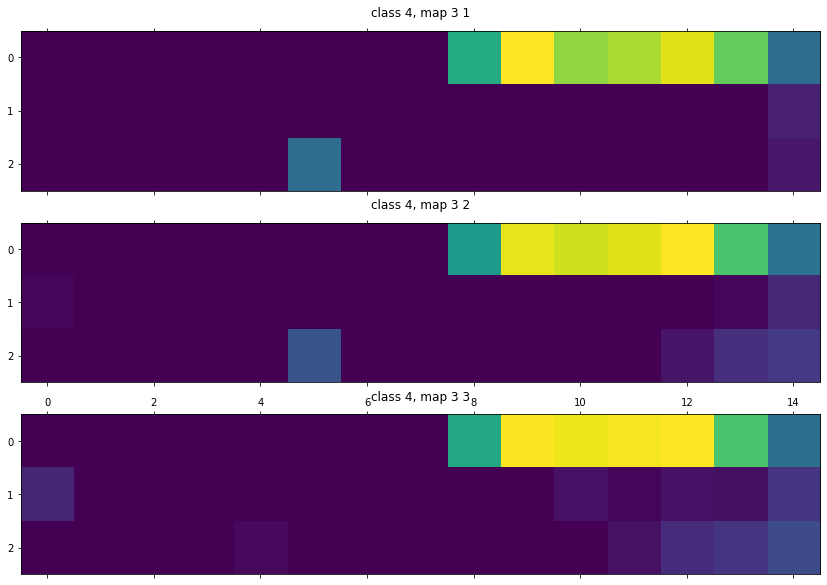

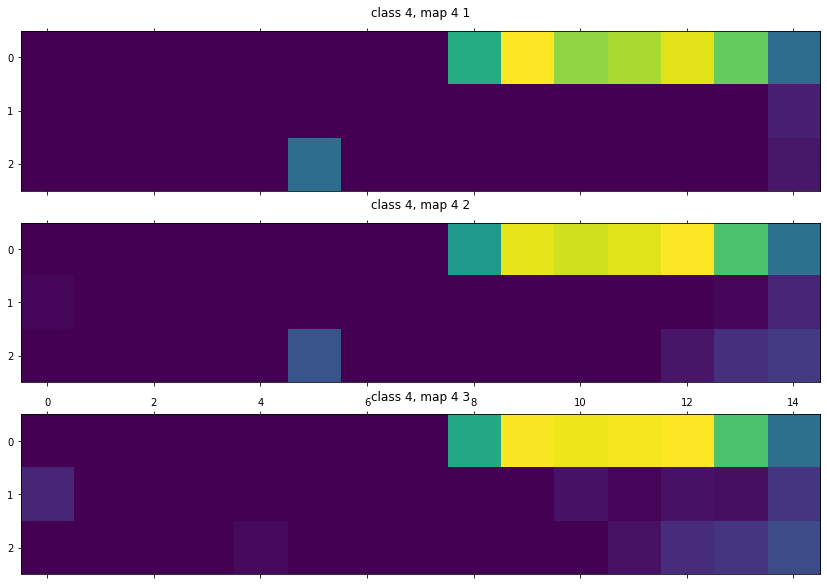

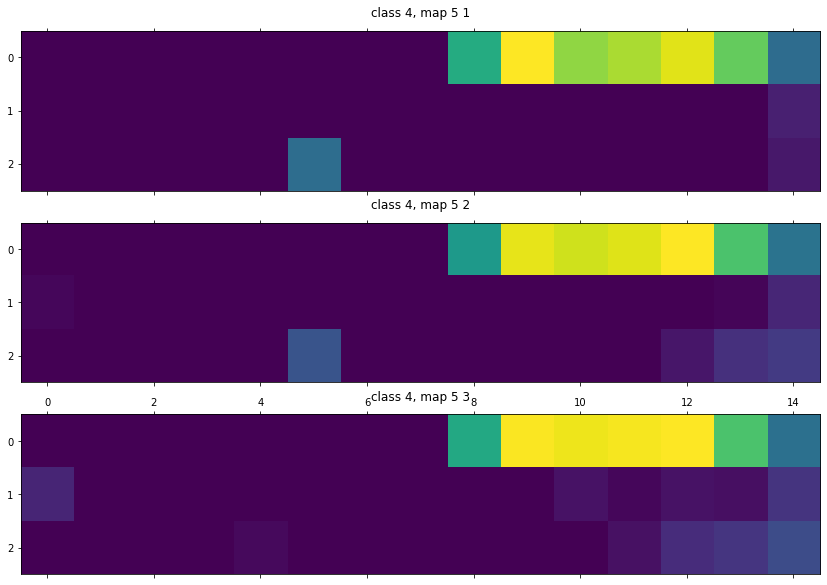

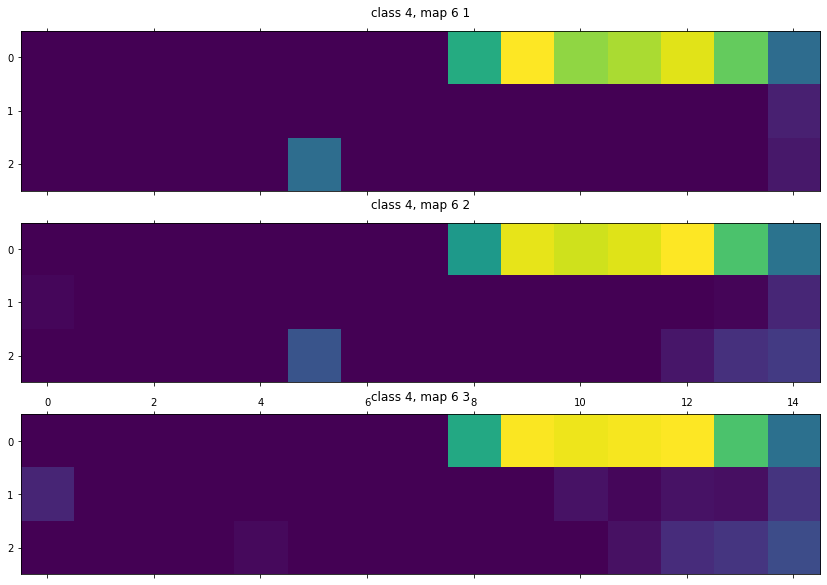

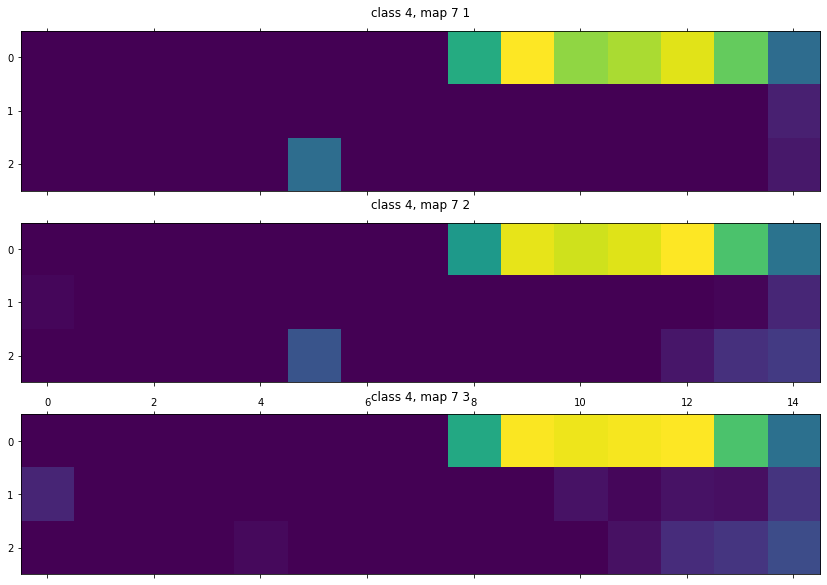

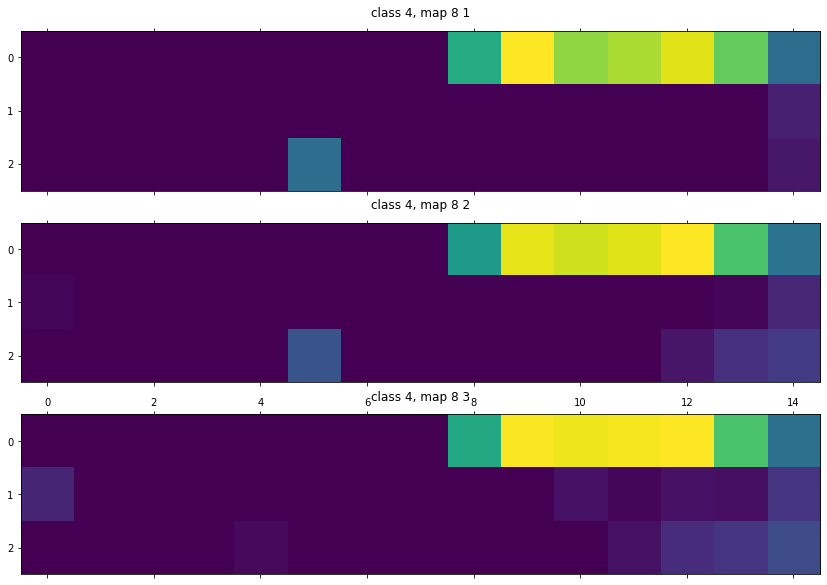

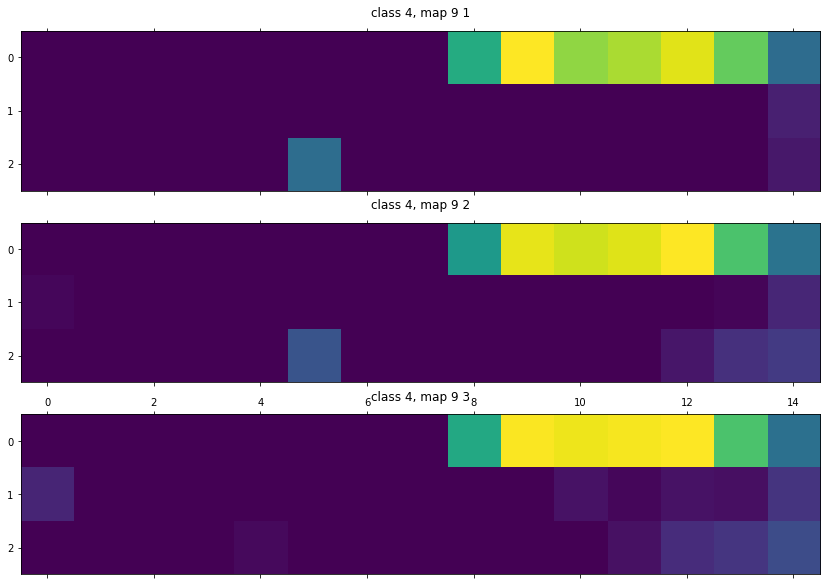

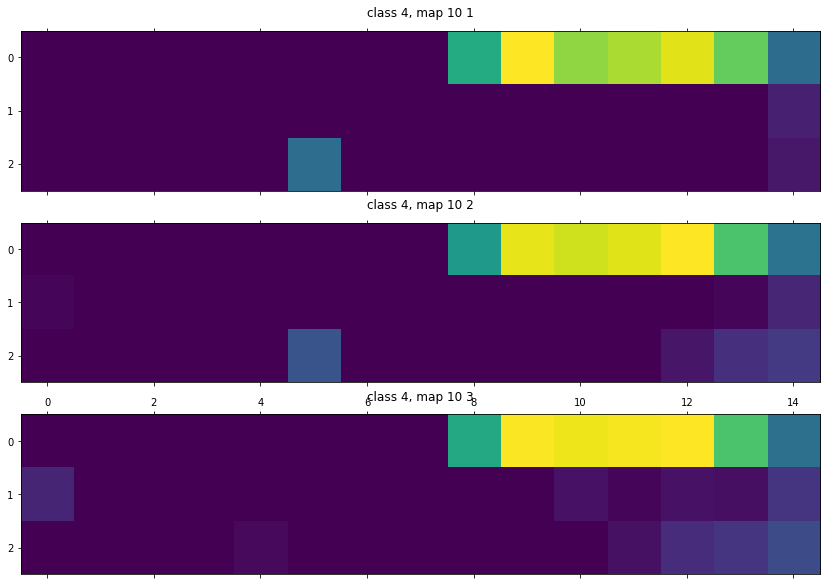

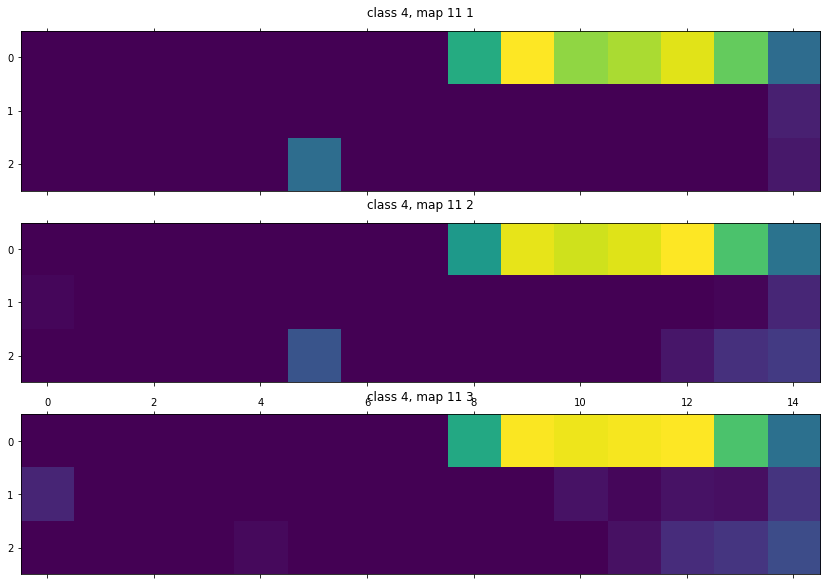

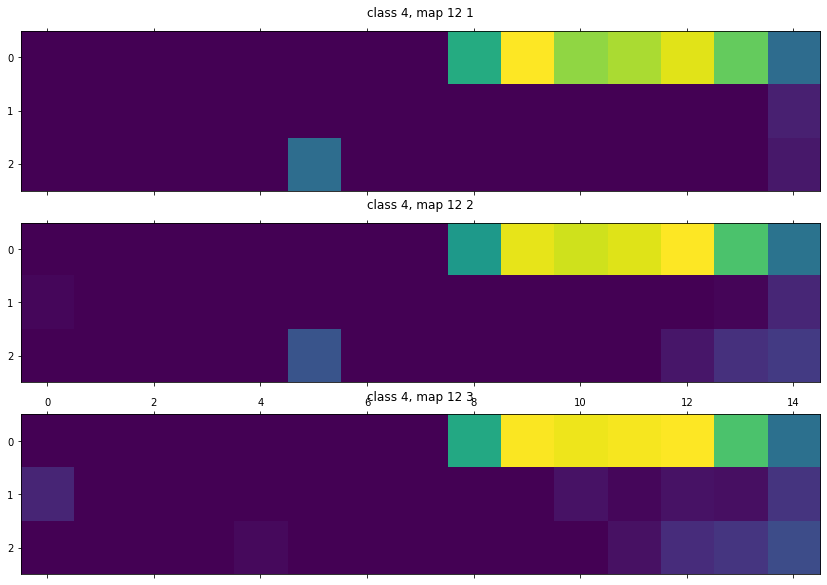

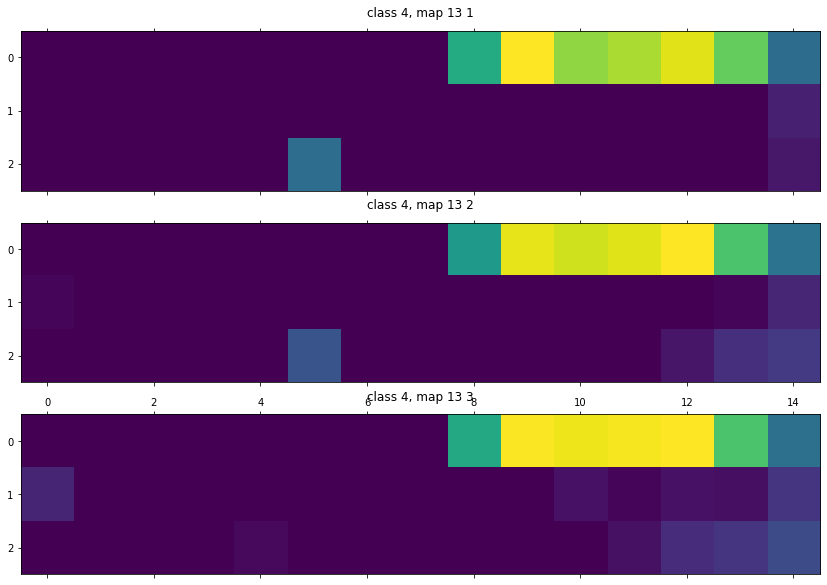

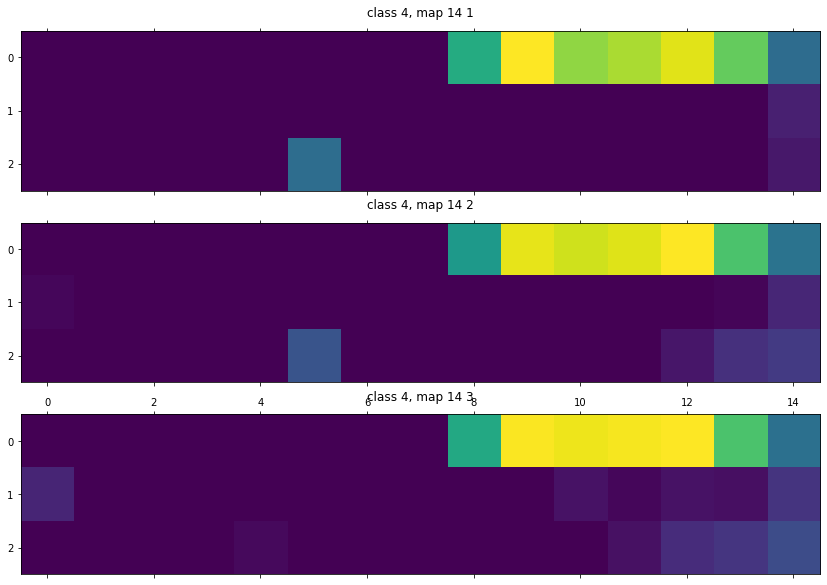

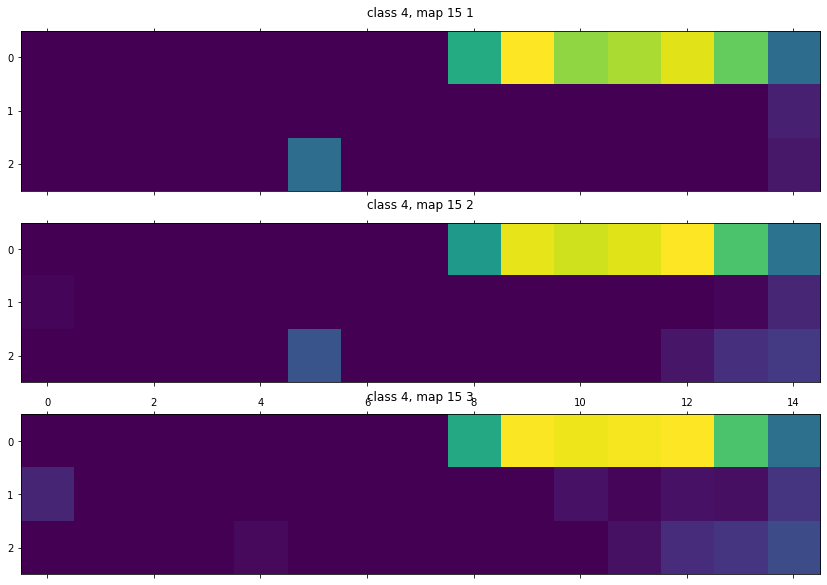

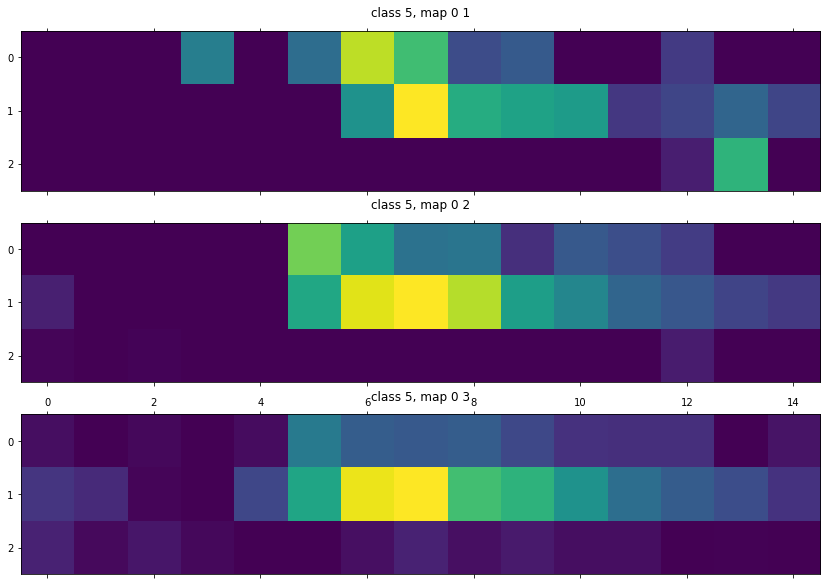

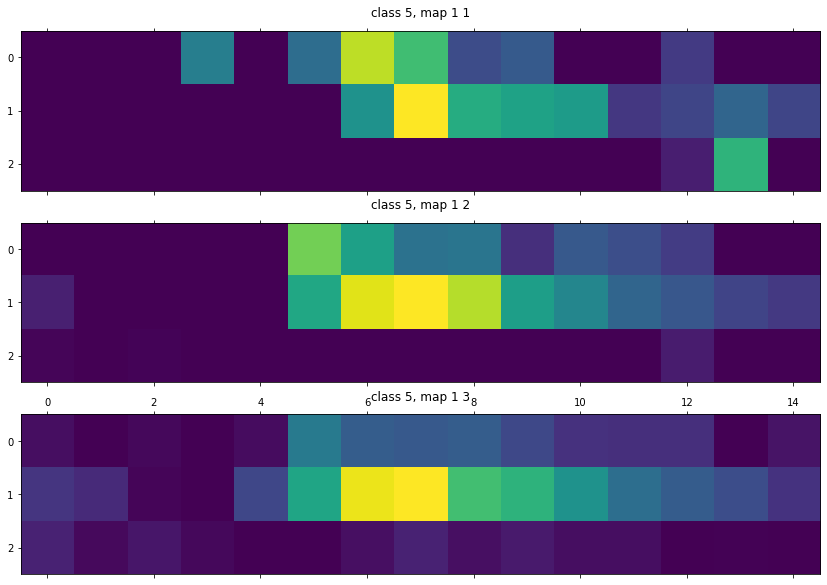

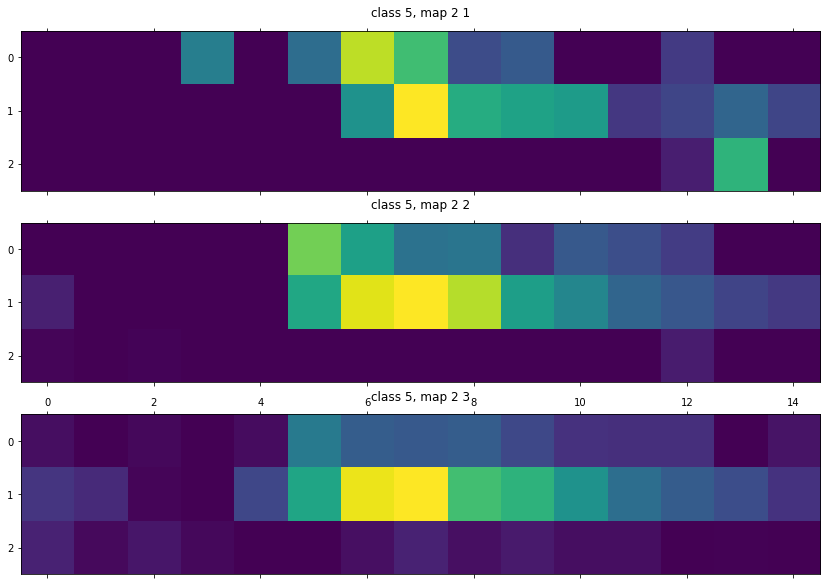

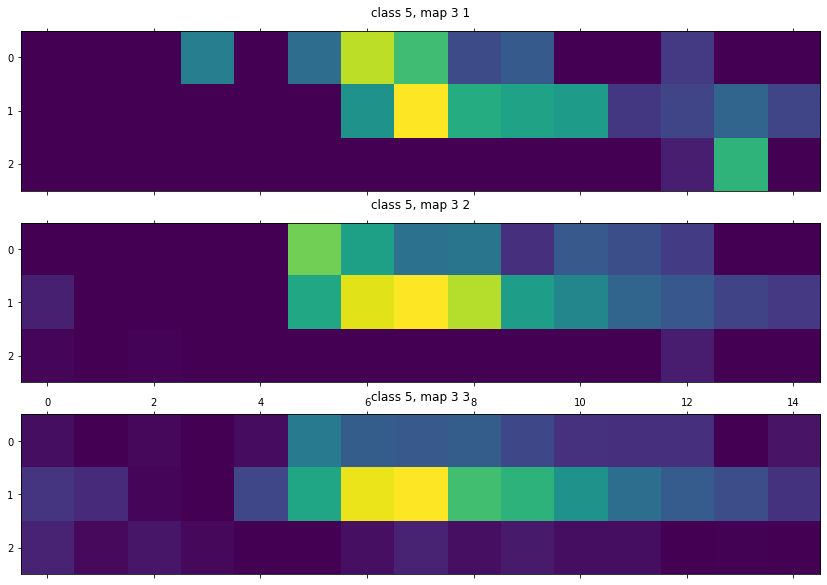

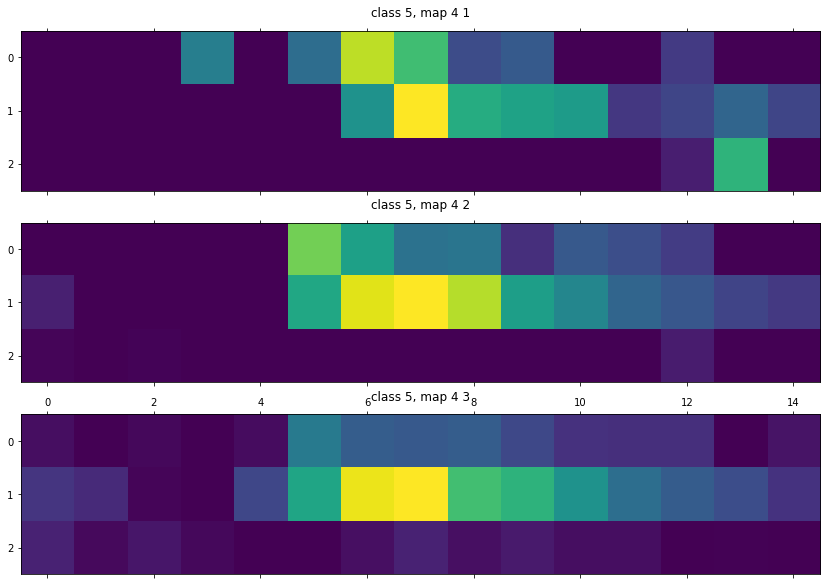

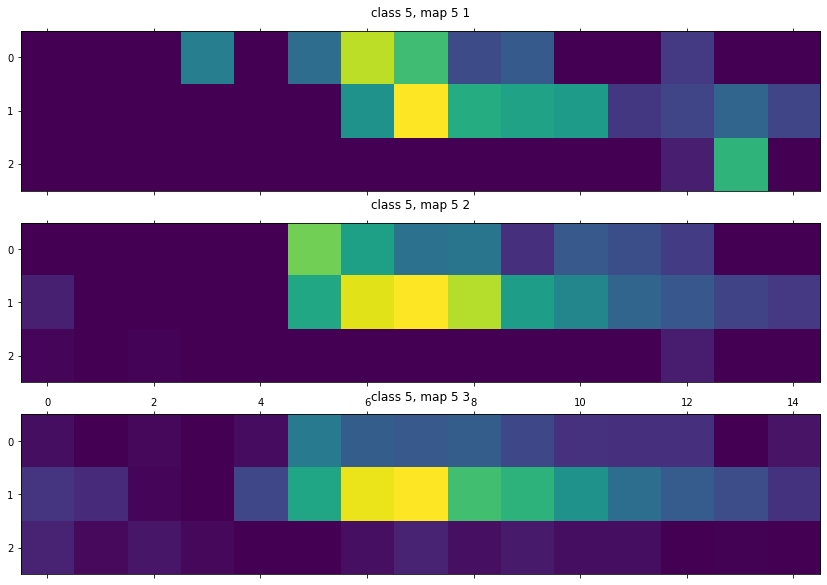

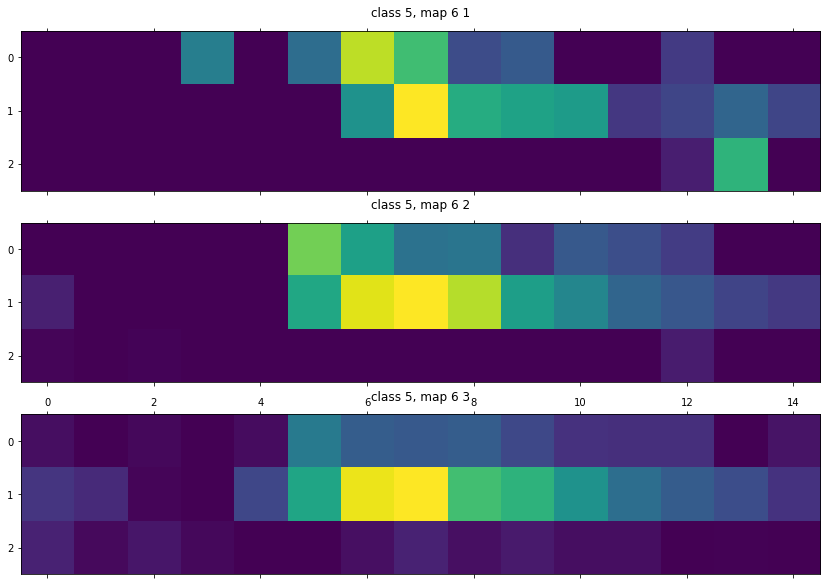

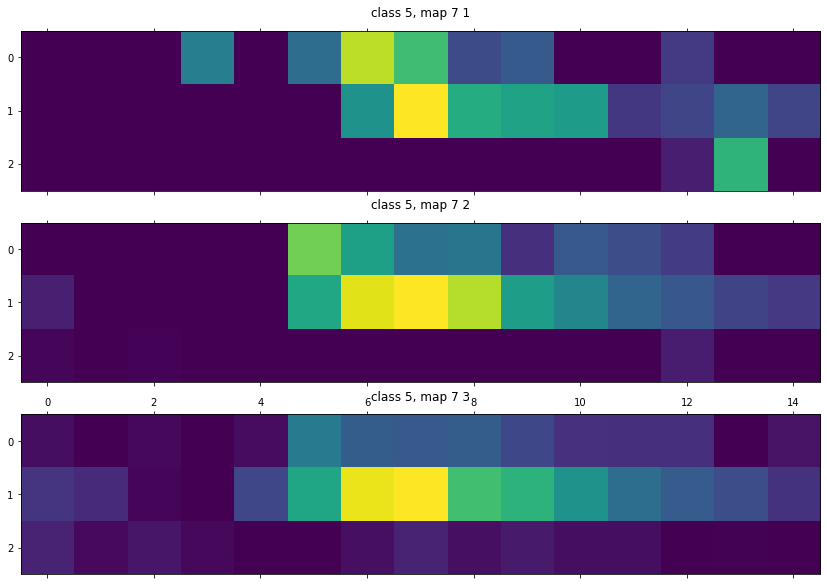

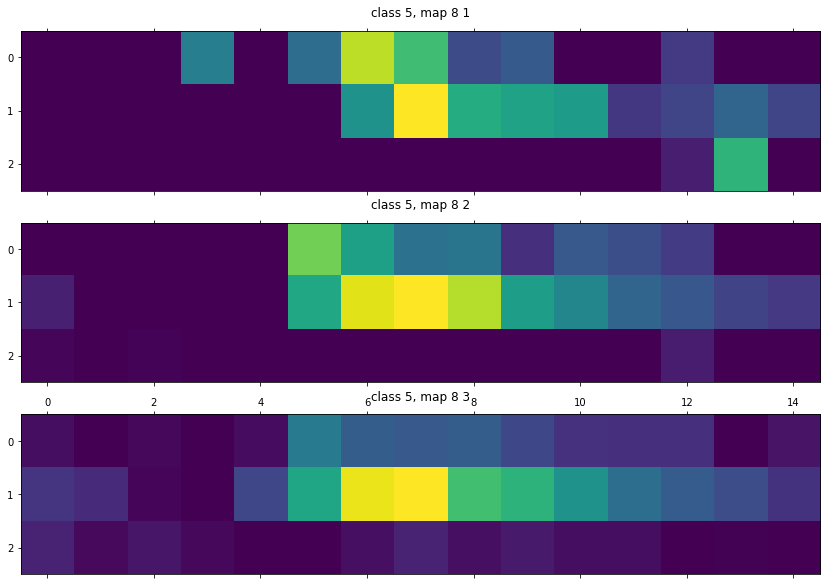

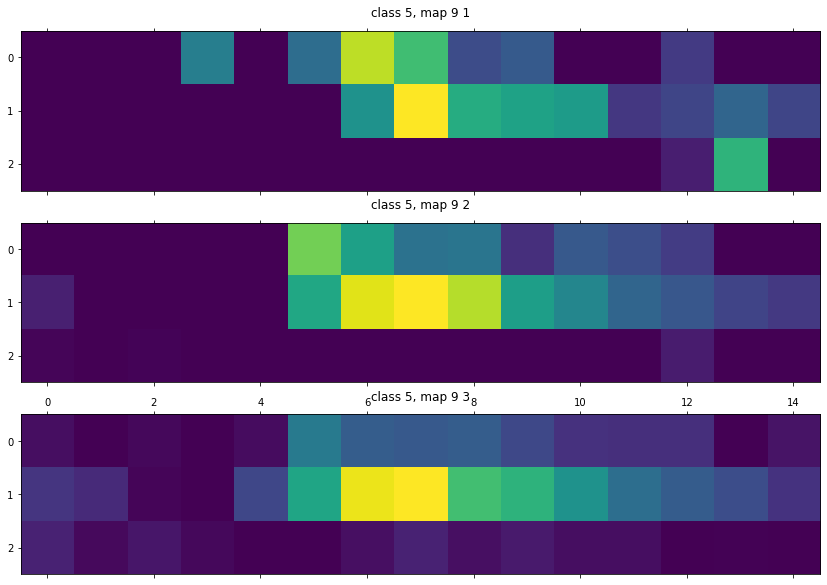

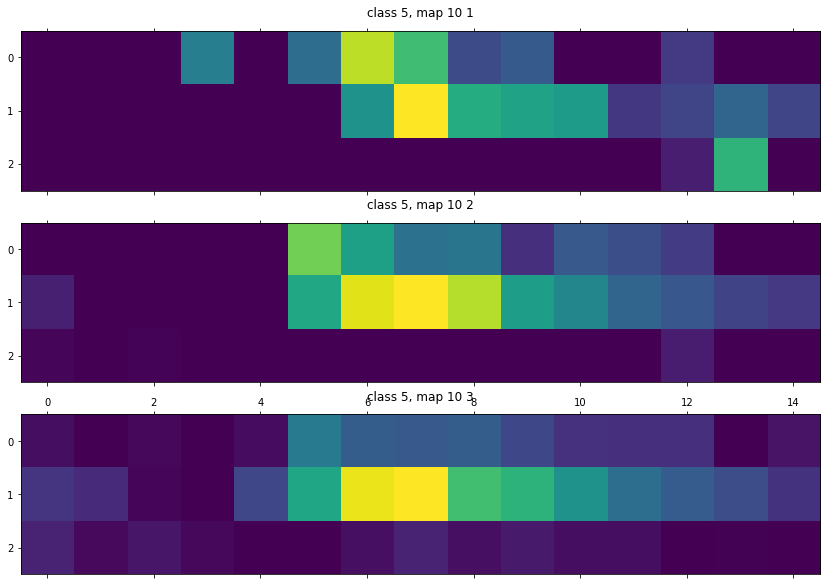

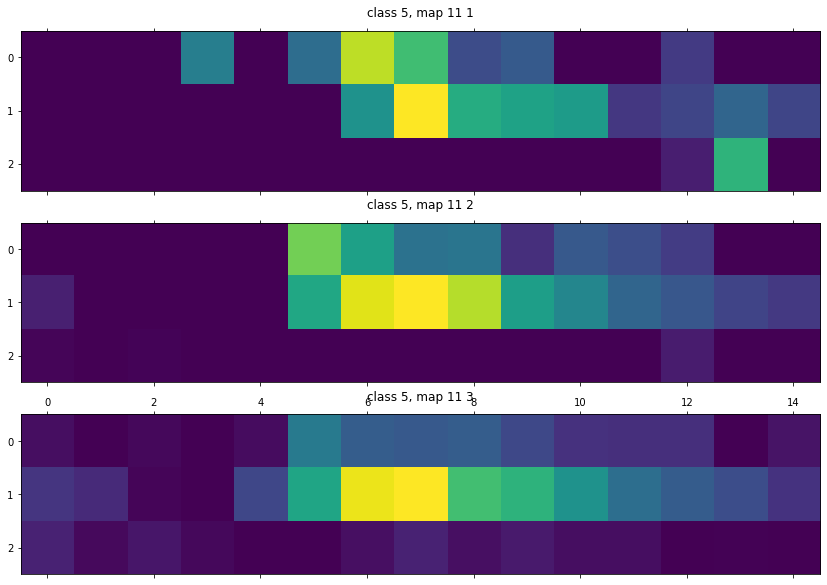

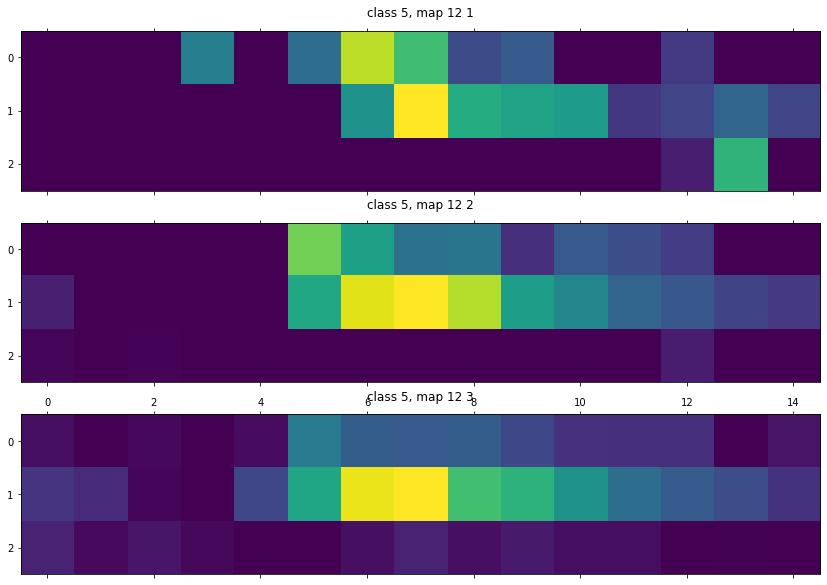

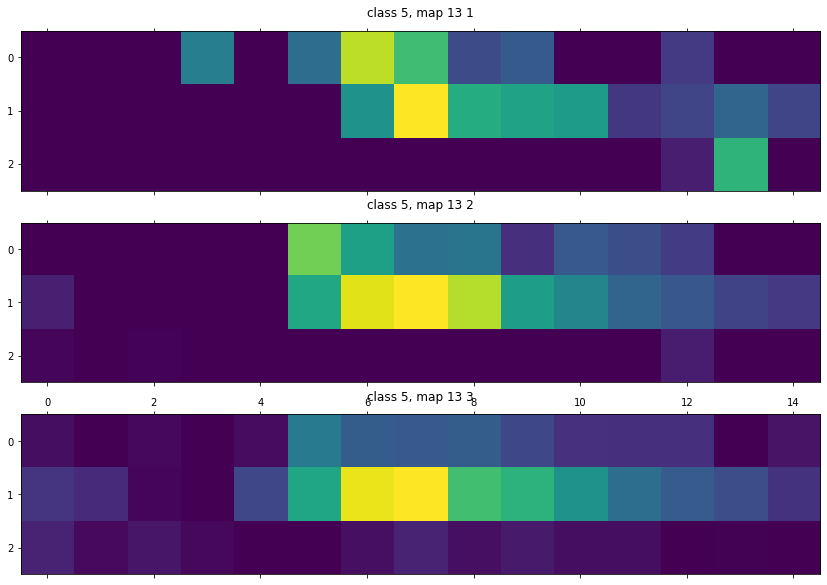

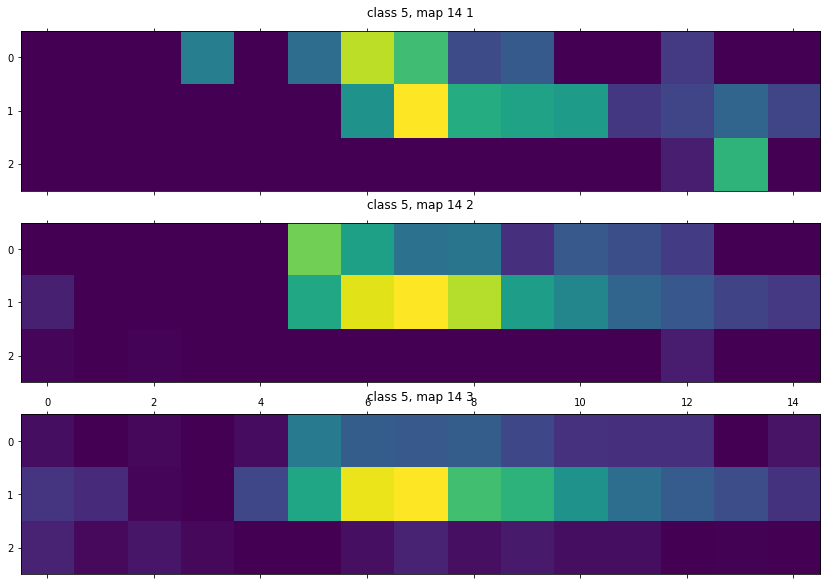

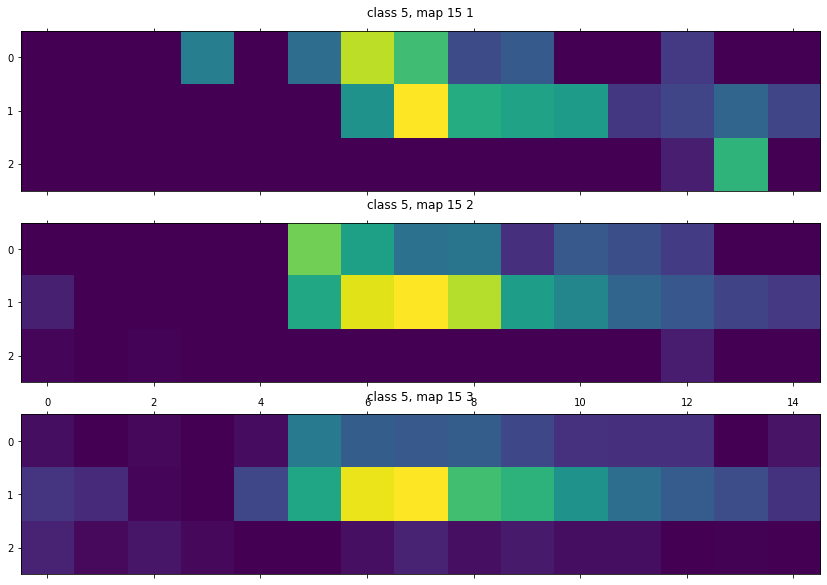

In [12]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.rcParams["figure.figsize"] = (30,10)
fig_roc, axs_roc = plt.subplots(2, 3, sharey = True, sharex = True )

models6 = []
for i in range(0,6):
    print('Class ' + str(i))
    dfi = df.copy()
    
    dfi.loc[dfi['class'] != i, 'class'] = -1
    dfi.loc[dfi['class'] == i, 'class'] = 1
    dfi.loc[dfi['class'] == -1, 'class'] = 0
    dfY = dfi['class']
    
    x_train, x_test, y_train, y_test = train_test_split(dataset_x, dfY, test_size=0.25)
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))
    
    model, scores = fitting_tensor(x_train, y_train)
    models6.append(model)
    print(scores)
    predictions = model.predict(x_test)

    print(x_test.shape)
    layer_outputs = [layer.output for layer in model.layers[:12]] 
    layer_outputs
    # Extracts the outputs of the top 12 layers
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
    activations = activation_model.predict(x_test[0].reshape((1,) + x_test[0].shape)) 

    first_layer_activation = activations[0]
    print(first_layer_activation.shape)
    first_layer_activation = first_layer_activation.reshape(first_layer_activation.shape[1], first_layer_activation.shape[2]* first_layer_activation.shape[3], first_layer_activation.shape[4])
    print(first_layer_activation.shape)
    
    for j in range(0, first_layer_activation.shape[2]):
        fig, axs = plt.subplots(3, 1, sharey = True, sharex = True )
        
        axs[0].set_title('class ' + str(i) + ', map ' + str(j) + ' 1')
        axs[0].matshow(first_layer_activation[:, :15, 15], cmap='viridis')
        
        axs[1].set_title('class ' + str(i) + ', map ' + str(j) + ' 2')
        axs[1].matshow(first_layer_activation[:, 16:31, 15], cmap='viridis')
        
        axs[2].set_title('class ' + str(i) + ', map ' + str(j) + ' 3')
        axs[2].matshow(first_layer_activation[:, 32:47, 15], cmap='viridis')
        
        fig.savefig("ECG90\\class" + str(i) + '_sample' + str(j) + ".png", dpi=100)  # results in 160x120 px image
        
    y_true = [x[1] for x in y_test]
    y_pred = np.array([x[1] for x in predictions])
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    
    axs_roc[i // 3, i % 3].set_title('ROC Curve for class ' + str(i))
    axs_roc[i // 3, i % 3].set(xlabel='false positive rate', ylabel='true positive rate')
    axs_roc[i // 3, i % 3].plot(fpr, tpr, colors[i] + '-')
    axs_roc[i // 3, i % 3].plot([0, 1], [0, 1], 'k' + '--')

    y_pred = np.array([round(x[1]) for x in predictions])
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.auc(fpr, tpr))
    print('\n')

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.rcParams["figure.figsize"] = (30,10)
fig, axs = plt.subplots(2, 3, sharey = True, sharex = True )

for i in range(0,6):
    print('Class ' + str(i))
    dfi = df.copy()
    
    dfi.loc[dfi['class'] != i, 'class'] = -1
    dfi.loc[dfi['class'] == i, 'class'] = 1
    dfi.loc[dfi['class'] == -1, 'class'] = 0

    dfX = dfi
    dfX = dfX.drop(columns='class')
    dfY = dfi['class']

    x_train, x_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.25)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    model, scores = fitting(x_train, y_train)
    print(scores)
    predictions = model.predict(x_test)
    
    y_true = [x[1] for x in y_test]
    y_pred = np.array([x[1] for x in predictions])
    
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    
    axs[i // 3, i % 3].set_title('ROC Curve for class ' + str(i))
    axs[i // 3, i % 3].set(xlabel='false positive rate', ylabel='true positive rate')
    axs[i // 3, i % 3].plot(fpr, tpr, colors[i] + '-')
    axs[i // 3, i % 3].plot([0, 1], [0, 1], 'k' + '--')

    y_pred = np.array([round(x[1]) for x in predictions])
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.auc(fpr, tpr))
    print('\n')

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.rcParams["figure.figsize"] = (30,10)
fig, axs = plt.subplots(2, 3, sharey = True, sharex = True )

for i in range(0,6):
    print('Class ' + str(i))
    dfi = df.copy()
    
    dfi.loc[dfi['class'] != i, 'class'] = -1
    dfi.loc[dfi['class'] == i, 'class'] = 1
    dfi.loc[dfi['class'] == -1, 'class'] = 0

    dfX = dfi
    dfX = dfX.drop(columns='class')
    dfY = dfi['class']

    x_train, x_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.25)
    
    ada = ADASYN()
    x_train, y_train = ada.fit_sample(x_train, y_train)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    model, scores = fitting(x_train, y_train)
    print(scores)
    predictions = model.predict(x_test)
    
    y_true = [x[1] for x in y_test]
    y_pred = np.array([x[1] for x in predictions])
    
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    
    axs[i // 3, i % 3].set_title('ROC Curve for class ' + str(i))
    axs[i // 3, i % 3].set(xlabel='false positive rate', ylabel='true positive rate')
    axs[i // 3, i % 3].plot(fpr, tpr, colors[i] + '-')
    axs[i // 3, i % 3].plot([0, 1], [0, 1], 'k' + '--')

    y_pred = np.array([round(x[1]) for x in predictions])
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.auc(fpr, tpr))
    print('\n')

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.rcParams["figure.figsize"] = (30,10)
fig, axs = plt.subplots(2, 3, sharey = True, sharex = True )

for i in range(0,6):
    print('Class ' + str(i))
    dfi = df.copy()
    
    dfi.loc[dfi['class'] != i, 'class'] = -1
    dfi.loc[dfi['class'] == i, 'class'] = 1
    dfi.loc[dfi['class'] == -1, 'class'] = 0

    dfX = dfi
    dfX = dfX.drop(columns='class')
    dfY = dfi['class']

    x_train, x_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.25)
    
    sm = [SMOTE()]
    for method in sm:
        x_train, y_train = method.fit_sample(x_train, y_train)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    model, scores = fitting(x_train, y_train)
    print(scores)
    predictions = model.predict(x_test)
    
    y_true = [x[1] for x in y_test]
    y_pred = np.array([x[1] for x in predictions])
    
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    
    axs[i // 3, i % 3].set_title('ROC Curve for class ' + str(i))
    axs[i // 3, i % 3].set(xlabel='false positive rate', ylabel='true positive rate')
    axs[i // 3, i % 3].plot(fpr, tpr, colors[i] + '-')
    axs[i // 3, i % 3].plot([0, 1], [0, 1], 'k' + '--')

    y_pred = np.array([round(x[1]) for x in predictions])
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.auc(fpr, tpr))
    print('\n')